# DSI16 - Capstone Project: 

# Recommender System for FMCGWholesale Trading

## Problem Statement

Fain Pte Ltd is an import/export company that deals with wholesale distribution of FMCG (Fast-Moving Consumer Goods) in Singapore. Their customers are local retailers, consisting of both the General Trade and Modern Trade. For this project, I am tasked to do some data analysis on the types of products that their customers are purchasing, and build a recommender system to recommend existing products that their customers might be interested in but have not purchased before. This recommender system will be used by the account managers to increase sales for their target customer, thus increasing overall revenue of the company. 

Increasing revenue comes in two ways: (i) increasing volume of items sold (ii) selling products with higher profit margin. In this project, we are particularly interested in looking at the quantity sold and the profit margin of the items sold. For case study, we will be using 'PINK BEAUTY PTE LTD' as they have average sales volume and we would like to push up the sales revenue from this company.

## Executive Summary

The raw dataset was provided by Fain Pte Ltd. It contains 5585 rows and 35 columns. In total, 93 companies were recorded and there are 549 unique products across 81 brands. It contains sales records across three months (July, August and September) in 2020. Data from September was incomplete as we extracted the data in mid-September. Other important informations include invoice number, quantity purchased, profit margin, unit price, total sales, category and brand. As the raw dataset had many missing information, we will need to clean and prepare the dataset before starting on analysis and building our recommendation system.

For data cleaning, the missing values for the columns 'category', 'brand' and 'invoice_no' were filled using the previous data, and the rest of the missing values were filled with zero. Datatypes for numerical data were converted from object to float or integer. Rows with negative profit margin, no unit cost and no unit proce information were dropped from the dataset. In total, 5.28% of rows were dropped.

We will be building five recommender systems and compare the results generated. The five systems are popularity model, content based filtering, user-based collaborative filtering, collaborative filtering with Singular Values Decomposition and Hybrid Model. After considering the pros and cons of each model, we can look at the combined results from all the five models and recommends the common items found in the top 10 recommendations from each model.

|Item Description|Popularity|CF|CB|SVD|Hybrid|
|:--|:--|:--|:--|:--|:--|
|Kirei-Kirei Handsoap AB+Antiseptic Agent Refill 200ml|Yes|No|Yes|No|Yes|
|Kirei-Kirei Handsoap AB Moist Peach Refill 200ml|Yes|No|Yes|No|Yes|
|Kirei-Kirei Handsoap AB Refreshing Grape Refill 200ml|Yes|Yes|No|No|No|
|Tiger Balm Mosquito Repellent Patch 10s|Yes|No|Yes|No|No|
|Colgate Toal 12 Clean Mint 150g|Yes|No|No|Yes|No|
|Colgate Total 12 Charcoal Deep Clean 150g|Yes|No|No|Yes|No|
|Simple Soap Bar Twinpack 2x125g|No|No|Yes|No|Yes|

Starting from this list, we make different recommendations to PINK BEAUTY over a period of next 3 months, and track which items that they will pick up and evaluate the models. We will also be tracking the total sales for these companies and determine how much the revenue increases with these recommendations.



### Contents
- [Data Collection](#Data-Collection)
- [Data Cleaning](#Data-Cleaning)
- [Features Extraction](#Features-Extraction)
- [EDA](#EDA)
- [Popularity Model](#Popularity-Model)
- [Content Based Filtering](#Content-Based-Filtering)
- [User-based Collaborative FIltering](#User-based-Collaborative-FIltering)
- [Collaborative Filtering with SVD](#Collaborative-Filtering-with-SVD)
- [Hybrid Model](#Hybrid-Model)
- [Conclusion](#Conclusion)


In [1]:
# Importing all the relevant libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

# Imports for Features Extraction
from nltk.corpus import stopwords
import gensim, spacy, logging, warnings
from gensim.utils import lemmatize, simple_preprocess
from sklearn.feature_extraction.text import CountVectorizer

# Imports for recommender's system
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from scipy.sparse.linalg import svds

# pd.set_option('display.max_columns', None)

### Data Collection
[top](#Contents)


In [2]:
df = pd.read_csv('datasets/customers.csv')

In [3]:
df.head()

,company,cateogory,brand,invoice_no,Unnamed: 4,item_code,item_description,local_sub_total_7,local_sub_total_8,local_sub_total_9,...,local_total_cost_7,local_total_cost_8,local_total_cost_9,Local SubTotal,Unit Cost,Local Profit,Profit Margin,Qty,Unit Price,Local Total Cost
0,ACE POWER PTE LTD,BABY CARE,Loreal,INV-20000010,NaN,5.011408e+12,Loreal Kids Shampoo Strawberry 250ml (1x6),326.40,NaN,NaN,...,280.5,NaN,NaN,326.40,2.7500,45.90,14.06%,102,3.2,280.5
1,ACE POWER PTE LTD,NaN,NaN,INV-20000381,NaN,3.600520e+12,Loreal Kids Conditioner Strawberry 250ml (1x6),NaN,268.80,NaN,...,NaN,242.4545,NaN,268.80,2.8864,26.35,9.80%,84,3.2,242.4545
2,ACE POWER PTE LTD,NaN,NaN,INV-20000490,NaN,3.600520e+12,Loreal Kids Conditioner Strawberry 250ml (1x6),NaN,268.80,NaN,...,NaN,243.5411,NaN,268.80,2.8993,25.26,9.40%,84,3.2,243.5411
3,ACTIVE SOLUTION MARKETING PTE LTD,PERSONAL CARE,Pex,INV-20000273,NaN,1.375705e+10,PEX Active Hand Sanitizer 500Ml (1x 24),180.00,NaN,NaN,...,144.,NaN,NaN,180.00,6.0000,36.00,20.00%,24,7.5,144.
4,AH HONG HOLDINGS PTE LTD,BABY CARE,Pediasure,INV-20000032,NaN,8.886451e+12,PEDIASURE MILK POWDER VANILA 1.6KG X 6PCS,318.00,NaN,NaN,...,272.58,NaN,NaN,318.00,45.4300,45.42,14.28%,6,53.0,272.58


In [4]:
df.shape

(5585, 35)

In [5]:
df.columns

Index(['company', 'cateogory', 'brand', 'invoice_no', 'Unnamed: 4',
       'item_code', 'item_description', 'local_sub_total_7',
       'local_sub_total_8', 'local_sub_total_9', 'unit_cost_7', 'unit_cost_8',
       'unit_cost_9', 'local_profit_7', 'local_profit_8', 'local_profit_9',
       'profit_margin_7', 'profit_margin_8', 'profit_margin_9', 'qty_7',
       'qty_8', 'qty_9', 'unit_price_7', 'unit_price_8', 'unit_price_9',
       'local_total_cost_7', 'local_total_cost_8', 'local_total_cost_9',
       'Local SubTotal', 'Unit Cost', 'Local Profit', 'Profit Margin', 'Qty',
       'Unit Price', 'Local Total Cost'],
      dtype='object')

In [6]:
# Renaming some of the columns to convert all to lower case and single word
df.rename(columns = {
    'cateogory':'category',
    'Local SubTotal': 'local_subtotal',
    'Unit Cost':'unit_cost',
    'Local Profit':'local_profit',
    'Profit Margin':'profit_margin',
    'Qty':'qty',
    'Unit Price':'unit_price',
    'Local Total Cost':'local_total_cost'}, inplace = True)

In [7]:
# Looking at the null values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5585 entries, 0 to 5584
Data columns (total 35 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   company             5558 non-null   object 
 1   category            494 non-null    object 
 2   brand               1148 non-null   object 
 3   invoice_no          2788 non-null   object 
 4   Unnamed: 4          0 non-null      float64
 5   item_code           5366 non-null   float64
 6   item_description    5366 non-null   object 
 7   local_sub_total_7   2466 non-null   object 
 8   local_sub_total_8   1967 non-null   object 
 9   local_sub_total_9   1125 non-null   object 
 10  unit_cost_7         2466 non-null   float64
 11  unit_cost_8         1967 non-null   float64
 12  unit_cost_9         1125 non-null   float64
 13  local_profit_7      2466 non-null   object 
 14  local_profit_8      1967 non-null   object 
 15  local_profit_9      1125 non-null   object 
 16  profit

In [8]:
# Dropping the empty column 'Unnamed: 4'
df.drop('Unnamed: 4',axis=1,inplace=True)
df.shape

(5585, 34)

In [9]:
df['company'].nunique()

93

In [10]:
df['item_code'].nunique()

549

In [11]:
df['brand'].nunique()

82

In [12]:
df['category'].unique()

array(['BABY CARE', nan, 'PERSONAL CARE', 'HOUSEHOLD', 'ORAL CARE',
       'PERFUME', 'BODY CARE', 'HAIR DYE', 'SKIN CARE', 'HAIR CARE',
       'MEDICAL'], dtype=object)

This dataset was collected from FAIN TRADING sales department. It contains sales records across three months (July, August and September) in 2020. Initially, there were 5585 entries (rows) and 39 columns. In total, we have 93 companies and 549 unique items in the record. Other important informations include quantity purchased, profit margin, unit price and category.

### Data Cleaning
[top](#Contents)

We need to prepare the data by filling in all the missing entries, removing unwanted rows/columns, changing the data types of some columns and also extract meaningful data from the existing one. 

In [13]:
# Checking number of missing values 
df.isnull().sum()

company                 27
category              5091
brand                 4437
invoice_no            2797
item_code              219
item_description       219
local_sub_total_7     3119
local_sub_total_8     3618
local_sub_total_9     4460
unit_cost_7           3119
unit_cost_8           3618
unit_cost_9           4460
local_profit_7        3119
local_profit_8        3618
local_profit_9        4460
profit_margin_7       3119
profit_margin_8       3618
profit_margin_9       4460
qty_7                 3119
qty_8                 3618
qty_9                 4460
unit_price_7          3119
unit_price_8          3618
unit_price_9          4460
local_total_cost_7    3119
local_total_cost_8    3618
local_total_cost_9    4460
local_subtotal          27
unit_cost               27
local_profit            27
profit_margin           27
qty                     27
unit_price              27
local_total_cost        27
dtype: int64

In [14]:
# ffill for category, brand and invoice no.
col = ['category','brand','invoice_no']
for c in col:
    df[c].fillna( method ='ffill', inplace = True) 

In [15]:
df[df['company'].isna()]

,company,category,brand,invoice_no,item_code,item_description,local_sub_total_7,local_sub_total_8,local_sub_total_9,unit_cost_7,...,local_total_cost_7,local_total_cost_8,local_total_cost_9,local_subtotal,unit_cost,local_profit,profit_margin,qty,unit_price,local_total_cost
5558,NaN,SKIN CARE,Simple,INV-20000420,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5559,NaN,SKIN CARE,Simple,INV-20000420,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5560,NaN,SKIN CARE,Simple,INV-20000420,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5561,NaN,SKIN CARE,Simple,INV-20000420,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5562,NaN,SKIN CARE,Simple,INV-20000420,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5563,NaN,SKIN CARE,Simple,INV-20000420,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5564,NaN,SKIN CARE,Simple,INV-20000420,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5565,NaN,SKIN CARE,Simple,INV-20000420,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5566,NaN,SKIN CARE,Simple,INV-20000420,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5567,NaN,SKIN CARE,Simple,INV-20000420,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [16]:
# Dropping all the rows where there is no data
i = df[df['company'].isna()].index
df.drop(i , inplace=True)

In [17]:
df.shape

(5558, 34)

In [18]:
df.isnull().sum()

company                  0
category                 0
brand                    0
invoice_no               0
item_code              192
item_description       192
local_sub_total_7     3092
local_sub_total_8     3591
local_sub_total_9     4433
unit_cost_7           3092
unit_cost_8           3591
unit_cost_9           4433
local_profit_7        3092
local_profit_8        3591
local_profit_9        4433
profit_margin_7       3092
profit_margin_8       3591
profit_margin_9       4433
qty_7                 3092
qty_8                 3591
qty_9                 4433
unit_price_7          3092
unit_price_8          3591
unit_price_9          4433
local_total_cost_7    3092
local_total_cost_8    3591
local_total_cost_9    4433
local_subtotal           0
unit_cost                0
local_profit             0
profit_margin            0
qty                      0
unit_price               0
local_total_cost         0
dtype: int64

In [19]:
df[df['item_code'].isna()]

,company,category,brand,invoice_no,item_code,item_description,local_sub_total_7,local_sub_total_8,local_sub_total_9,unit_cost_7,...,local_total_cost_7,local_total_cost_8,local_total_cost_9,local_subtotal,unit_cost,local_profit,profit_margin,qty,unit_price,local_total_cost
1991,JNC LINE (S) PTE LTD,SKIN CARE,Simple,INV-20000272,NaN,NaN,0.00,NaN,NaN,0.0,...,0.,NaN,NaN,0.00,0.0,0.00,0.00%,0,0.0,0.
1993,JUMBO MINIMART,PERSONAL CARE,Pex,INV-20000119,NaN,NaN,0.00,NaN,NaN,0.0,...,0.,NaN,NaN,0.00,0.0,0.00,0.00%,0,0.0,0.
2018,KAI QUEN TRADING ENTERPRISE,SKIN CARE,Garnier,INV-20000140,NaN,NaN,0.00,NaN,NaN,0.0,...,0.,NaN,NaN,0.00,0.0,0.00,0.00%,0,0.0,0.
2019,KAI QUEN TRADING ENTERPRISE,SKIN CARE,Garnier,INV-20000211,NaN,NaN,0.00,NaN,NaN,0.0,...,0.,NaN,NaN,0.00,0.0,0.00,0.00%,0,0.0,0.
2020,KAI QUEN TRADING ENTERPRISE,SKIN CARE,Garnier,INV-20000227,NaN,NaN,0.00,NaN,NaN,0.0,...,0.,NaN,NaN,0.00,0.0,0.00,0.00%,0,0.0,0.
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5457,ZHEN TAT ENTERPRISE,SKIN CARE,Garnier,INV-20000113,NaN,NaN,0.00,NaN,NaN,0.0,...,0.,NaN,NaN,0.00,0.0,0.00,0.00%,0,0.0,0.
5458,ZHEN TAT ENTERPRISE,SKIN CARE,Garnier,INV-20000114,NaN,NaN,0.00,NaN,NaN,0.0,...,0.,NaN,NaN,0.00,0.0,0.00,0.00%,0,0.0,0.
5459,ZHEN TAT ENTERPRISE,SKIN CARE,Garnier,INV-20000156,NaN,NaN,0.00,NaN,NaN,0.0,...,0.,NaN,NaN,0.00,0.0,0.00,0.00%,0,0.0,0.
5460,ZHEN TAT ENTERPRISE,SKIN CARE,Garnier,INV-20000201,NaN,NaN,0.00,NaN,NaN,0.0,...,0.,NaN,NaN,0.00,0.0,0.00,0.00%,0,0.0,0.


In [20]:
# Dropping rows with no item information
i = df[df['item_code'].isna()].index
df.drop(i , inplace=True)

In [21]:
df.shape

(5366, 34)

In [22]:
df.isnull().sum()

company                  0
category                 0
brand                    0
invoice_no               0
item_code                0
item_description         0
local_sub_total_7     3075
local_sub_total_8     3412
local_sub_total_9     4245
unit_cost_7           3075
unit_cost_8           3412
unit_cost_9           4245
local_profit_7        3075
local_profit_8        3412
local_profit_9        4245
profit_margin_7       3075
profit_margin_8       3412
profit_margin_9       4245
qty_7                 3075
qty_8                 3412
qty_9                 4245
unit_price_7          3075
unit_price_8          3412
unit_price_9          4245
local_total_cost_7    3075
local_total_cost_8    3412
local_total_cost_9    4245
local_subtotal           0
unit_cost                0
local_profit             0
profit_margin            0
qty                      0
unit_price               0
local_total_cost         0
dtype: int64

In [23]:
# Fill all other missing values as 0
df.fillna(0, inplace=True)

In [24]:
# Checking that there are no more null value.
df.isnull().sum().sum()

0

In [25]:
df.dtypes

company                object
category               object
brand                  object
invoice_no             object
item_code             float64
item_description       object
local_sub_total_7      object
local_sub_total_8      object
local_sub_total_9      object
unit_cost_7           float64
unit_cost_8           float64
unit_cost_9           float64
local_profit_7         object
local_profit_8         object
local_profit_9         object
profit_margin_7        object
profit_margin_8        object
profit_margin_9        object
qty_7                  object
qty_8                  object
qty_9                  object
unit_price_7          float64
unit_price_8          float64
unit_price_9          float64
local_total_cost_7     object
local_total_cost_8     object
local_total_cost_9     object
local_subtotal         object
unit_cost             float64
local_profit           object
profit_margin          object
qty                    object
unit_price            float64
local_tota

Many columns with numerical data are being stored as object, these need to be converted to float or int.

In [26]:
# removing the ',' in local_subtotal column and convert to float
df['local_subtotal'] = df['local_subtotal'].map(lambda x: float(x.replace(',','')))

In [27]:
df.columns

Index(['company', 'category', 'brand', 'invoice_no', 'item_code',
       'item_description', 'local_sub_total_7', 'local_sub_total_8',
       'local_sub_total_9', 'unit_cost_7', 'unit_cost_8', 'unit_cost_9',
       'local_profit_7', 'local_profit_8', 'local_profit_9', 'profit_margin_7',
       'profit_margin_8', 'profit_margin_9', 'qty_7', 'qty_8', 'qty_9',
       'unit_price_7', 'unit_price_8', 'unit_price_9', 'local_total_cost_7',
       'local_total_cost_8', 'local_total_cost_9', 'local_subtotal',
       'unit_cost', 'local_profit', 'profit_margin', 'qty', 'unit_price',
       'local_total_cost'],
      dtype='object')

In [28]:
col_to_convert = ['local_sub_total_7', 'local_sub_total_8', 'local_sub_total_9',
                  'local_profit_7', 'local_profit_8', 'local_profit_9',
                  'local_total_cost_7', 'local_total_cost_8', 'local_total_cost_9',
                  'local_profit', 'local_total_cost']

In [29]:
# Converting columns with pricing from object to float type
for col in col_to_convert:
    df[col] = df[col].astype(str)
    df[col] = df[col].map(lambda x: float(x.replace(',','')))

In [30]:
# Identifying row with -4900% profit margin
df[df['profit_margin_7']=='-4,900.00%']

,company,category,brand,invoice_no,item_code,item_description,local_sub_total_7,local_sub_total_8,local_sub_total_9,unit_cost_7,...,local_total_cost_7,local_total_cost_8,local_total_cost_9,local_subtotal,unit_cost,local_profit,profit_margin,qty,unit_price,local_total_cost
4314,STAFF PURCHASES,PERSONAL CARE,Onine,INV-20000031,301020.0,ONINE Disposal Mask 50pcs/box,20.0,0.0,0.0,20.0,...,1000.0,0.0,0.0,20.0,20.0,-980.0,"-4,900.00%",50,0.4,1000.0


In [31]:
# Removing row with -4900%
df.drop(4314, inplace=True)

In [32]:
col_margin = ['profit_margin_7', 'profit_margin_8', 'profit_margin_9', 'profit_margin']

# removing the '%' in margin columns and convert to float
for col in col_margin:
    df[col] = df[col].astype(str)
    df[col] = df[col].map(lambda x: float(x.replace('%','')))

In [33]:
col_qty = ['qty_7', 'qty_8', 'qty_9', 'qty']

# converting qty columns to int type
for col in col_qty:
    df[col] = df[col].astype(str)
    df[col] = df[col].map(lambda x: int(x.replace(',','')))

In [34]:
# Checking that all the column datatypes are correct
df.dtypes

company                object
category               object
brand                  object
invoice_no             object
item_code             float64
item_description       object
local_sub_total_7     float64
local_sub_total_8     float64
local_sub_total_9     float64
unit_cost_7           float64
unit_cost_8           float64
unit_cost_9           float64
local_profit_7        float64
local_profit_8        float64
local_profit_9        float64
profit_margin_7       float64
profit_margin_8       float64
profit_margin_9       float64
qty_7                   int64
qty_8                   int64
qty_9                   int64
unit_price_7          float64
unit_price_8          float64
unit_price_9          float64
local_total_cost_7    float64
local_total_cost_8    float64
local_total_cost_9    float64
local_subtotal        float64
unit_cost             float64
local_profit          float64
profit_margin         float64
qty                     int64
unit_price            float64
local_tota

#### Removing rows with no unit cost or unit price information

There were rows with missing unit_cost or unit_price information and we will drop these rows.

In [35]:
df['unit_cost'].describe()

count    5365.000000
mean        4.120238
std         8.618928
min         0.000000
25%         1.680000
50%         2.400000
75%         4.400000
max       298.190000
Name: unit_cost, dtype: float64

In [36]:
df['unit_price'].describe()

count    5365.000000
mean        5.221555
std         9.682262
min         0.000000
25%         2.100000
50%         3.000000
75%         5.650000
max       316.000000
Name: unit_price, dtype: float64

In [37]:
df[df['unit_price']==0]

,company,category,brand,invoice_no,item_code,item_description,local_sub_total_7,local_sub_total_8,local_sub_total_9,unit_cost_7,...,local_total_cost_7,local_total_cost_8,local_total_cost_9,local_subtotal,unit_cost,local_profit,profit_margin,qty,unit_price,local_total_cost
855,DIAN ESSENTIALS,BODY CARE,Sebamed,INV-20000322,9.314108e+12,Sebamed Liq Face & Body Wash 300ml,0.0,0.0,0.0,0.0,...,0.0,12.0,0.0,0.0,2.0,-12.0,0.0,6,0.0,12.0
1234,FLAUNT IT,BODY CARE,Sebamed,INV-20000009,9.314108e+12,Sebamed Liq Face & Body Wash 300ml,0.0,0.0,0.0,2.0,...,144.0,0.0,0.0,0.0,2.0,-144.0,0.0,72,0.0,144.0
1236,FLAUNT IT,BODY CARE,Sebamed,INV-20000299,9.314108e+12,Sebamed Liq Face & Body Wash 300ml,0.0,0.0,0.0,0.0,...,0.0,80.0,0.0,0.0,2.0,-80.0,0.0,40,0.0,80.0
1238,FLAUNT IT,BODY CARE,Sebamed,INV-20000507,9.314108e+12,Sebamed Liq Face & Body Wash 300ml,0.0,0.0,0.0,0.0,...,0.0,152.0,0.0,0.0,2.0,-152.0,0.0,76,0.0,152.0
2314,MAYSON ESSENTIALS PTE. LTD.,BODY CARE,Sebamed,INV-20000362,9.314108e+12,Sebamed Liq Face & Body Wash 300ml,0.0,0.0,0.0,0.0,...,0.0,12.0,0.0,0.0,2.0,-12.0,0.0,6,0.0,12.0


In [38]:
df[df['unit_cost']==0]

,company,category,brand,invoice_no,item_code,item_description,local_sub_total_7,local_sub_total_8,local_sub_total_9,unit_cost_7,...,local_total_cost_7,local_total_cost_8,local_total_cost_9,local_subtotal,unit_cost,local_profit,profit_margin,qty,unit_price,local_total_cost
100,ANN TENG HENG,HAIR CARE,Good Look,INV-20000147,8.888036e+12,Good Look Hair Moisturizer 240ml (1x72),25.2,0.00,0.00,0.0,...,0.0,0.0,0.0,25.20,0.0,25.20,100.0,6,4.20,0.0
321,BAN LONG MEDICAL HALL,BABY CARE,Johnson,INV-20000052,9.556006e+12,Johnson Baby Lotion Mildness 500ml (1x 12),19.8,0.00,0.00,0.0,...,0.0,0.0,0.0,19.80,0.0,19.80,100.0,6,3.30,0.0
436,BEST DEAL SHOP 3,HAIR CARE,Loreal,INV-20000419,3.600521e+12,Loreal Studio Fix & Shine Finishing Spray 250ml,0.0,27.00,0.00,0.0,...,0.0,0.0,0.0,27.00,0.0,27.00,100.0,6,4.50,0.0
666,CK DEPARTMENT STORE PTE LTD,HAIR CARE,Essential,INV-20000426,4.898889e+12,Essential Shp Weightlessly Smooth 700ml (1x6),0.0,40.50,0.00,0.0,...,0.0,0.0,0.0,40.50,0.0,40.50,100.0,9,4.50,0.0
667,CK DEPARTMENT STORE PTE LTD,HAIR CARE,Essential,INV-20000426,4.898889e+12,Essential Shp Tame & Control 700ml (1x6),0.0,153.00,0.00,0.0,...,0.0,0.0,0.0,153.00,0.0,153.00,100.0,34,4.50,0.0
668,CK DEPARTMENT STORE PTE LTD,HAIR CARE,Essential,INV-20000426,4.898889e+12,Essential Cond Nourishing Breakage Defense 700ml,0.0,36.00,0.00,0.0,...,0.0,0.0,0.0,36.00,0.0,36.00,100.0,8,4.50,0.0
669,CK DEPARTMENT STORE PTE LTD,HAIR CARE,Essential,INV-20000426,4.898889e+12,Essential Conditioner Weightlessly Smooth 700ml,0.0,18.00,0.00,0.0,...,0.0,0.0,0.0,18.00,0.0,18.00,100.0,4,4.50,0.0
670,CK DEPARTMENT STORE PTE LTD,HAIR CARE,Essential,INV-20000426,4.898889e+12,Essential Cond Deep Cleansing Care 700ml (1x6),0.0,22.50,0.00,0.0,...,0.0,0.0,0.0,22.50,0.0,22.50,100.0,5,4.50,0.0
671,CK DEPARTMENT STORE PTE LTD,HAIR CARE,Essential,INV-20000426,4.898889e+12,Essential Conditional Tame & Control 700ml (1x6),0.0,157.50,0.00,0.0,...,0.0,0.0,0.0,157.50,0.0,157.50,100.0,35,4.50,0.0
760,CK DEPARTMENT STORE PTE LTD,SKIN CARE,Garnier,INV-20000428,8.992304e+12,GARNIER MEN Turbo Light Oil Control Icy Scrub ...,0.0,42.84,0.00,0.0,...,0.0,0.0,0.0,42.84,0.0,42.84,100.0,18,2.38,0.0


In [39]:
# Dropping all the rows where there is no unit cost
i = df[df['unit_cost']==0].index
df.drop(i , inplace=True)

In [40]:
# Dropping all the rows where there is no unit price
i = df[df['unit_price']==0].index
df.drop(i , inplace=True)

In [41]:
df.shape

(5331, 34)

#### Removing Rows with negative profit margin

These rows with negative profit margin came from internal purchases or staff purchases as company benefits. We want to exclude these data for our analysis.

In [42]:
df[df['profit_margin']<0]

,company,category,brand,invoice_no,item_code,item_description,local_sub_total_7,local_sub_total_8,local_sub_total_9,unit_cost_7,...,local_total_cost_7,local_total_cost_8,local_total_cost_9,local_subtotal,unit_cost,local_profit,profit_margin,qty,unit_price,local_total_cost
402,BENKING PTE LTD,BABY CARE,Mustela,INV-20000257,3.504105e+12,Mustela Gentle Cleasing Gel 500ml (1x24),5640.00,0.0,0.00,6.0900,...,7308.0000,0.0000,0.0000,5640.00,6.0900,-1668.00,-29.57,1200,4.70,7308.0000
405,BENKING PTE LTD,SKIN CARE,Embryolisse,INV-20000257,3.350900e+12,Embryolisse Multi-function nourishing moisturizer,1680.00,0.0,0.00,14.5000,...,1740.0000,0.0000,0.0000,1680.00,14.5000,-60.00,-3.57,120,14.00,1740.0000
411,BEST DEAL SHOP,HOUSEHOLD,Dettol,INV-20000451,8.901396e+12,Dettol Antiseptic Liquid 60ml,0.00,60.0,0.00,0.0000,...,0.0000,60.7500,0.0000,60.00,0.8100,-0.75,-1.25,75,0.80,60.7500
426,BEST DEAL SHOP 2,HOUSEHOLD,Dettol,INV-20000418,8.901396e+12,Dettol Antiseptic Liquid 60ml,0.00,60.0,0.00,0.0000,...,0.0000,60.7500,0.0000,60.00,0.8100,-0.75,-1.25,75,0.80,60.7500
441,BEST DEAL SHOP 3,HOUSEHOLD,Dettol,INV-20000419,8.901396e+12,Dettol Antiseptic Liquid 60ml,0.00,60.0,0.00,0.0000,...,0.0000,60.7500,0.0000,60.00,0.8100,-0.75,-1.25,75,0.80,60.7500
676,CK DEPARTMENT STORE PTE LTD,HAIR CARE,Loreal,INV-20000087,8.992304e+12,L'Oreal Elseve Fall Resist Shampoo 650ml (1x6),577.08,0.0,0.00,9.9488,...,1253.5428,0.0000,0.0000,577.08,9.9488,-676.46,-117.22,126,4.58,1253.5428
749,CK DEPARTMENT STORE PTE LTD,PERSONAL CARE,Lifebuoy,INV-20000520,8.901031e+12,Lifebuoy Hand Wash Total 10 Refill 750ml (1x12),0.00,8004.0,0.00,0.0000,...,0.0000,9604.8000,0.0000,8004.00,2.7600,-1600.80,-20.00,3480,2.30,9604.8000
907,DIAN ESSENTIALS,PERSONAL CARE,Lifebuoy,INV-20000595,8.901031e+12,Lifebuoy Hand Wash Total 10 Refill 750ml (1x12),0.00,0.0,62.10,0.0000,...,0.0000,0.0000,63.4800,62.10,2.7600,-1.38,-2.22,23,2.70,63.4800
1009,ELP STORE,HOUSEHOLD,Dettol,INV-20000034,8.901396e+12,Dettol Antiseptic Liquid 60ml,18.00,0.0,0.00,0.8100,...,19.4400,0.0000,0.0000,18.00,0.8100,-1.44,-8.00,24,0.75,19.4400
1074,ELP STORE HOLLAND,HOUSEHOLD,Dettol,INV-20000036,8.901396e+12,Dettol Antiseptic Liquid 60ml,18.00,0.0,0.00,0.8100,...,19.4400,0.0000,0.0000,18.00,0.8100,-1.44,-8.00,24,0.75,19.4400


In [43]:
# Dropping all the rows where there profit margin is negative
i = df[df['profit_margin']<0].index
df.drop(i , inplace=True)

In [44]:
df.shape

(5290, 34)

In [45]:
# Perentage of rows dropped
(5585-5290)/5585

0.052820053715308866

In [46]:
df['item_description'].nunique()

528

In [47]:
df['company'].nunique()

92

In total, about 5.28% of rows were dropped. Data is now ready for EDA. After cleaning the data, we have 92 retail companies and 528 unique products.

### Features Extraction
[top](#Contents)

To prepare our dataset for building our recommendation system, we need to extract item features for content-based filtering. From the dataset, the column 'category' will be used as one of the item features. Other item features that we can create includes size that we need to extract from the item description. We will classify them into 5 different classes: mini, small, medium, large and extra large.

Besides the size of item, we want to create sub-categories like 'shampoo', 'toothpaste' etc. We will extract meaningful words by using the count vectorizer to give us the sub-categories.

#### Item Features from Size

In [48]:
# Extract the numerical information from the item_description column
def extract_size(txt):
    return re.findall('\d+\w+',txt)

In [49]:
# Store this information in a new column 'extracted_qty'
df['extracted_qty'] = df['item_description'].apply(extract_size)

In [50]:
df.head(20)

,company,category,brand,invoice_no,item_code,item_description,local_sub_total_7,local_sub_total_8,local_sub_total_9,unit_cost_7,...,local_total_cost_8,local_total_cost_9,local_subtotal,unit_cost,local_profit,profit_margin,qty,unit_price,local_total_cost,extracted_qty
0,ACE POWER PTE LTD,BABY CARE,Loreal,INV-20000010,5.011408e+12,Loreal Kids Shampoo Strawberry 250ml (1x6),326.4,0.0,0.0,2.75,...,0.0000,0.0,326.4,2.7500,45.90,14.06,102,3.20,280.5000,"[250ml, 1x6]"
1,ACE POWER PTE LTD,BABY CARE,Loreal,INV-20000381,3.600520e+12,Loreal Kids Conditioner Strawberry 250ml (1x6),0.0,268.8,0.0,0.00,...,242.4545,0.0,268.8,2.8864,26.35,9.80,84,3.20,242.4545,"[250ml, 1x6]"
2,ACE POWER PTE LTD,BABY CARE,Loreal,INV-20000490,3.600520e+12,Loreal Kids Conditioner Strawberry 250ml (1x6),0.0,268.8,0.0,0.00,...,243.5411,0.0,268.8,2.8993,25.26,9.40,84,3.20,243.5411,"[250ml, 1x6]"
3,ACTIVE SOLUTION MARKETING PTE LTD,PERSONAL CARE,Pex,INV-20000273,1.375705e+10,PEX Active Hand Sanitizer 500Ml (1x 24),180.0,0.0,0.0,6.00,...,0.0000,0.0,180.0,6.0000,36.00,20.00,24,7.50,144.0000,"[500Ml, 1x, 24]"
4,AH HONG HOLDINGS PTE LTD,BABY CARE,Pediasure,INV-20000032,8.886451e+12,PEDIASURE MILK POWDER VANILA 1.6KG X 6PCS,318.0,0.0,0.0,45.43,...,0.0000,0.0,318.0,45.4300,45.42,14.28,6,53.00,272.5800,"[6KG, 6PCS]"
5,AH HONG HOLDINGS PTE LTD,BABY CARE,Pediasure,INV-20000320,8.886451e+12,PEDIASURE MILK POWDER VANILA 1.6KG X 6PCS,0.0,318.0,0.0,0.00,...,272.5800,0.0,318.0,45.4300,45.42,14.28,6,53.00,272.5800,"[6KG, 6PCS]"
6,AH HONG HOLDINGS PTE LTD,HOUSEHOLD,Dettol,INV-20000551,5.011418e+12,Dettol Spray Neutra Air Revitalising Fresh Bre...,0.0,0.0,21.0,0.00,...,0.0000,15.0,21.0,2.5000,6.00,28.57,6,3.50,15.0000,"[300ml, 1x6]"
7,AH HONG HOLDINGS PTE LTD,HOUSEHOLD,Glade,INV-20000551,5.000205e+12,Glade Spray Silver Aero Soft Cotton 300ml (1x12),0.0,0.0,10.2,0.00,...,0.0000,8.1,10.2,1.3500,2.10,20.59,6,1.70,8.1000,"[300ml, 1x12]"
8,AH HONG HOLDINGS PTE LTD,HOUSEHOLD,Glade,INV-20000551,5.000205e+12,Glade Spray Silver Aero Vanilla Cream 300ml (1...,0.0,0.0,10.2,0.00,...,0.0000,8.1,10.2,1.3500,2.10,20.59,6,1.70,8.1000,"[300ml, 1x12]"
9,AH HONG HOLDINGS PTE LTD,ORAL CARE,Colgate,INV-20000032,9.556031e+12,Colgate Maximum Cavity Great Regular Flavor 25...,27.6,0.0,0.0,1.83,...,0.0000,0.0,27.6,1.8300,5.64,20.43,12,2.30,21.9600,"[250g, 1x48]"


In [51]:
# Keep only the size information in the column and remove carton information
df['extracted_size'] = df['extracted_qty'].map(lambda x: x[0].lower() if len(x)!=0 else '0')

In [52]:
df['extracted_size'].unique()

array(['250ml', '500ml', '6kg', '300ml', '250g', '200ml', '230ml', '75ml',
       '400ml', '881', '882', '883', '884', '1l', '3000ml', '750ml',
       '100ml', '40ml', '220ml', '50', '56s', '700', '600ml', '650ml',
       '99', '26', '120gx48', '150ml', '600mlx24', '0', '325ml', '330ml',
       '2b', '500mlx12', '170ml', '125ml', '700ml', '170g', '2l',
       '1500ml', '6l', '360g', '7cmx10cm', '10cmx14cm', '10s', '12',
       '01mm', '2x100g', '50pcs', '10ml', '40s', '10', '50ml', '30', '8g',
       '80g', '12x10', '2s', '12x6', '1x12', '20', '32', '40cm', '17',
       '25s', '3x', '550g', '130g', '1x48', '150gx72', '1000ml',
       '300mlx1', '25cm', '22cm', '40', '1kg', '2x125g', '2in1', '240ml',
       '2yrs', '5yrs', '100g', '127g', '32oz', '1x20', '450g', '12yrs',
       '160gx12', '800ml', '22', '30cm', '295ml', '453g', '1x10', '4s',
       '20ml', '46', '180g', '145ml', '90ml', '32s', '50g', '160g',
       '200g', '15', '550ml', '10roll', '1x24', '900ml', '2x500ml', '85',
     

In [53]:
# Extract the ml / g/ litre information from the size column
def extract_ml(txt):
    return re.findall('\d+ml|\d+g|\d+kg|\d+l',txt)
df['extracted_size']= df['extracted_size'].apply(extract_ml)
df['extracted_size'] = df['extracted_size'].map(lambda x: x[0].lower() if len(x)!=0 else '0')

In [54]:
df['extracted_size'].unique()

array(['250ml', '500ml', '6kg', '300ml', '250g', '200ml', '230ml', '75ml',
       '400ml', '0', '1l', '3000ml', '750ml', '100ml', '40ml', '220ml',
       '600ml', '650ml', '120g', '150ml', '325ml', '330ml', '170ml',
       '125ml', '700ml', '170g', '2l', '1500ml', '6l', '360g', '100g',
       '10ml', '50ml', '8g', '80g', '550g', '130g', '150g', '1000ml',
       '1kg', '125g', '240ml', '127g', '450g', '160g', '800ml', '295ml',
       '453g', '20ml', '180g', '145ml', '90ml', '50g', '200g', '550ml',
       '900ml', '450ml', '385ml', '85g', '10g', '20g', '130ml', '2000ml',
       '3l', '2800g', '3kg', '1400g', '3600g', '4000g', '1600g', '5l',
       '60ml', '15ml', '70ml'], dtype=object)

In [55]:
# Regrouping into 5 different sizes
# mini size: < 100
# small size: < 400
# medium size: < 1000
# large size: < 3000
# extra large: >= 3000

mini_size = ['15ml','10g', '20g','70ml','85g','90ml', '50g','20ml','60ml','10ml', '50ml', '8g', '80g','40ml','75ml']
small_size = ['200g','385ml','130g', '150g','180g', '145ml','295ml','125g', '127g','100g','130g', '150g',
              '170ml', '125ml','170g','360g','120g', '150ml', '240ml', '325ml', '330ml','100ml','220ml',
              '230ml','300ml', '250g', '200ml', '250ml','160g']
medium_size = ['550ml', '900ml', '450ml','800ml','550g','453g','550g','700ml','600ml', '650ml','400ml','750ml','500ml']
large_size = ['2000ml','2800g','1400g','1600g','1000ml', '1kg','2l', '1500ml','1l']
extra_large = ['5l','3l','3kg','3600g', '4000g','6l','3000ml','6kg']

In [56]:
def map_size(size):
    if size in small_size:
        return 'small'
    elif size in mini_size:
        return 'mini'
    elif size in medium_size:
        return 'medium'
    elif size in large_size:
        return 'large'
    elif size in extra_large:
        return 'x-large'
    else:
        return 'nil'

In [57]:
df['size'] = df['extracted_size'].apply(map_size)

In [58]:
df['size'].value_counts()

nil        1634
small      1549
medium     1187
large       400
mini        385
x-large     135
Name: size, dtype: int64

5 new features are being created from the size of item.

#### Item Features from Count Vectorizer
[top](#Contents)

In [59]:
# Defining stopwords
stop_words = stopwords.words('english')
stop_words.extend(df['brand'].unique())
stop_words.extend(("speedy", "kirei", "th", "uk", "ab", "total", "refill", "soft",
                   "soft", "white", "anti", "clean", "refreshing", "mint", "radiance", "light", 
                   "regular", "tiger", "lemon", "cool", "oreal", "natural", "dry", "control",
                   "grape", "elseve", "mold", "large", "purifying", "stain", "trigger", "revitalift",
                   "ultra", "black", "charcoal", "medium", "original", "plax", "milk", "extra",
                   "strawberry", "slim", "perfect", "night", "repair", "fall", "color"))
stop_words = [x.lower() for x in stop_words]

In [60]:
# define a function to remove size and ctn information from item descriptions
# Remove stopwords from item description

def sent_to_words(sentences):
    for sent in sentences:
        sent = re.sub('(\d\w+)', '', sent)
        sent = re.sub('[\(\)]', '', sent.lower())
        sent = gensim.utils.simple_preprocess(str(sent), deacc=True) 
        # Remove stopwords from "words."
        sent =  [w for w in sent if w not in stop_words]
        yield(sent)  


# Creating a list of item descriptions
content = df['item_description'].values.tolist()
content_words = list(sent_to_words(content))
content_words[:3]

[['kids', 'shampoo'], ['kids', 'conditioner'], ['kids', 'conditioner']]

In [61]:
# Checking the first 10 items
content_words[:10]

[['kids', 'shampoo'],
 ['kids', 'conditioner'],
 ['kids', 'conditioner'],
 ['active', 'hand', 'sanitizer'],
 ['powder', 'vanila'],
 ['powder', 'vanila'],
 ['spray', 'neutra', 'air', 'revitalising', 'breeze'],
 ['spray', 'silver', 'aero', 'cotton'],
 ['spray', 'silver', 'aero', 'vanilla', 'cream'],
 ['maximum', 'cavity', 'great', 'flavor']]

In [62]:
# Joining the individual key words in an item as a string
content_str = [' '.join(w) for w in content_words]

In [63]:
# Checking the string
content_str[:3]

['kids shampoo', 'kids conditioner', 'kids conditioner']

In [64]:
# Instantiate a CountVectorizer.
cvec = CountVectorizer()

In [65]:
content_str = cvec.fit_transform(content_str)

In [66]:
# Convert into a DataFrame.

content_df = pd.DataFrame(content_str.toarray(),
                          columns=cvec.get_feature_names())
content_df

,accessories,acne,acno,action,active,advance,advanced,aero,age,agent,...,wipes,women,wr,wrinkl,wrinkle,yellow,yrs,yuzu,zag,zig
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5285,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5286,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5287,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5288,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [67]:
# Identifying top 42 words from item description
top_words = content_df.sum().sort_values(ascending=False).head(42)
top_words

skin            345
care            332
gentle          329
cream           323
baby            307
men             299
gum             287
hair            247
wash            247
cleanser        242
shampoo         239
toothpaste      237
foam            235
spray           233
cleaner         195
moisturising    192
cleansing       182
bathroom        182
gel             173
lotion          171
handsoap        168
head            163
facial          151
body            150
oil             147
softener        140
balm            132
toilet          120
whitening       119
bath            115
mouthwash       108
liquid          107
scrub           107
laundry         100
toothbrush       98
bleach           91
kitchen          91
firming          89
hand             82
eye              81
soap             80
moisturizing     79
dtype: int64

<AxesSubplot:>

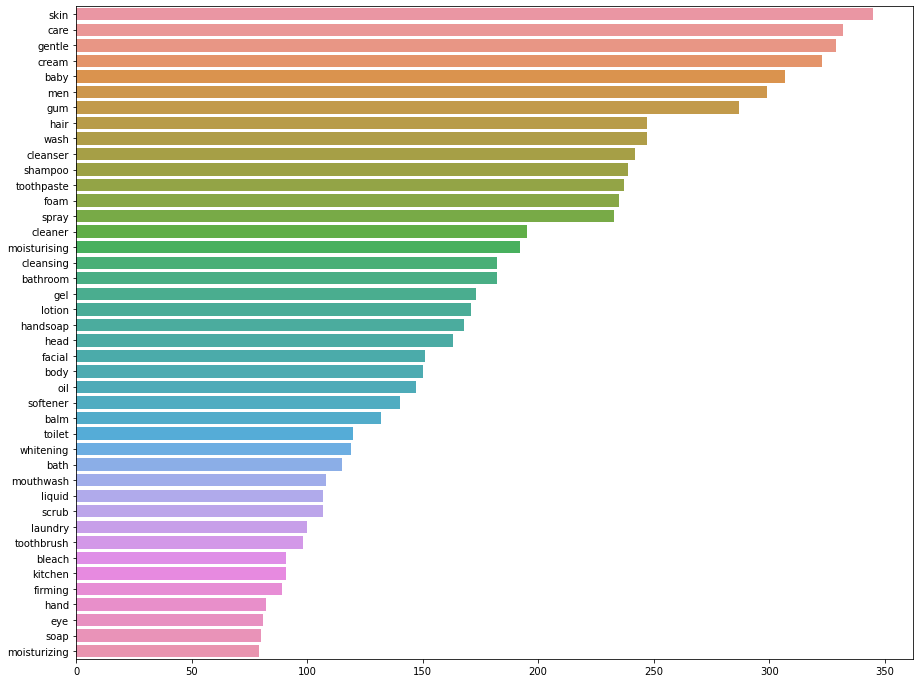

In [68]:
plt.figure(figsize=(15,12))
sns.barplot(x=top_words.values, y=top_words.index)

In [69]:
top_words.index.tolist()

['skin',
 'care',
 'gentle',
 'cream',
 'baby',
 'men',
 'gum',
 'hair',
 'wash',
 'cleanser',
 'shampoo',
 'toothpaste',
 'foam',
 'spray',
 'cleaner',
 'moisturising',
 'cleansing',
 'bathroom',
 'gel',
 'lotion',
 'handsoap',
 'head',
 'facial',
 'body',
 'oil',
 'softener',
 'balm',
 'toilet',
 'whitening',
 'bath',
 'mouthwash',
 'liquid',
 'scrub',
 'laundry',
 'toothbrush',
 'bleach',
 'kitchen',
 'firming',
 'hand',
 'eye',
 'soap',
 'moisturizing']

In [70]:
# Keeping only the 42 columns with the top key words in the dataframe
content_df = content_df[top_words.index.tolist()]
content_df.head()

,skin,care,gentle,cream,baby,men,gum,hair,wash,cleanser,...,scrub,laundry,toothbrush,bleach,kitchen,firming,hand,eye,soap,moisturizing
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


These 42 key words are selected as additional item features.

### EDA
[top](#Contents)

#### Profit Margin

In [71]:
# define a function to plot frequency distributions
def plot_freq(df, col):
    
    plt.figure(figsize=(12,8))
    sns.distplot(df[col]).set_title("Frequency Distribution of {}".format(col),fontsize=20)
    
    plt.figure(figsize=(13,5))
    sns.boxplot(x=df[col], color="skyblue").set_title("Boxplot of {}".format(col),fontsize=20)
    

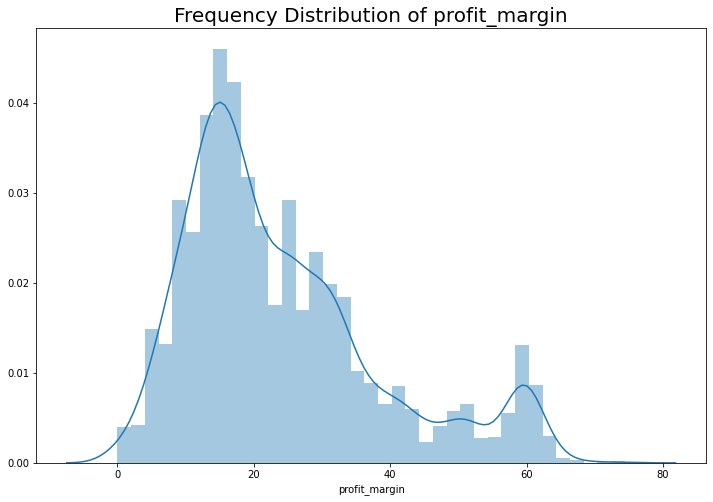

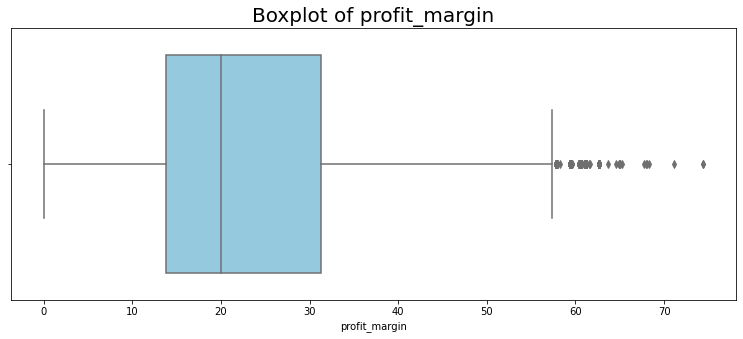

In [72]:
plot_freq(df, 'profit_margin')

In [73]:
high_margin = df.groupby('item_description')['profit_margin'].mean().sort_values(ascending=False).head(20)

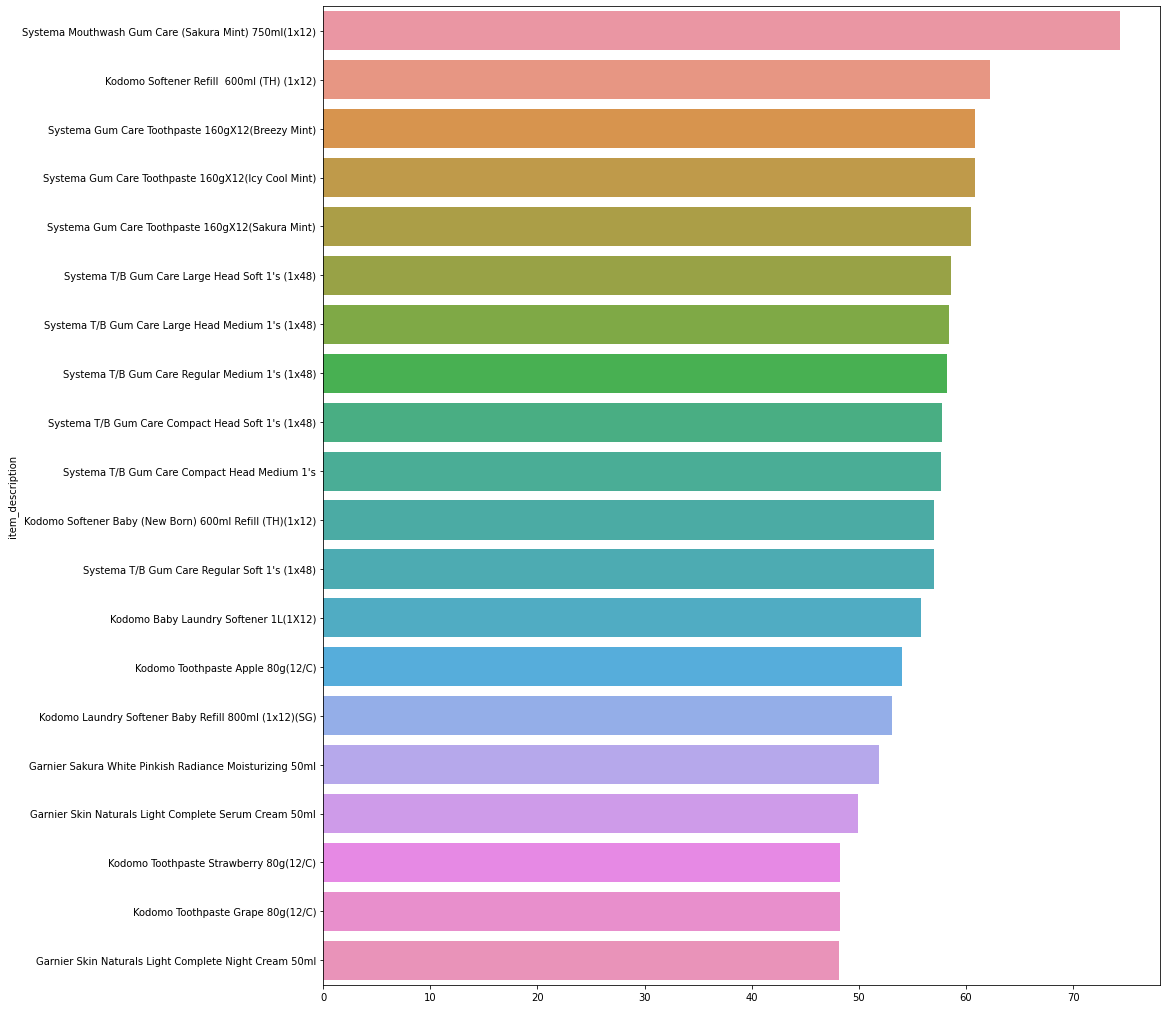

In [74]:
plt.figure(figsize=(15,18))
hm_plot = sns.barplot(x=high_margin.values, y=high_margin.index);

In [75]:
df['profit_margin'].describe()

count    5290.000000
mean       24.086032
std        14.583233
min         0.000000
25%        13.750000
50%        20.015000
75%        31.295000
max        74.400000
Name: profit_margin, dtype: float64

The mean profit margin is about 24% and the median profit margin is about 20%. This is because the frequency distribution is skewed right. Majority of the items has profit margin of between 13% to 31.3%. 

#### Quantity Purchased

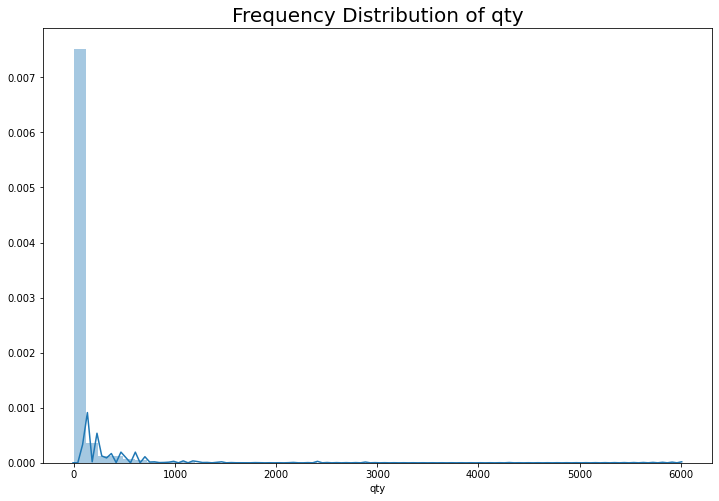

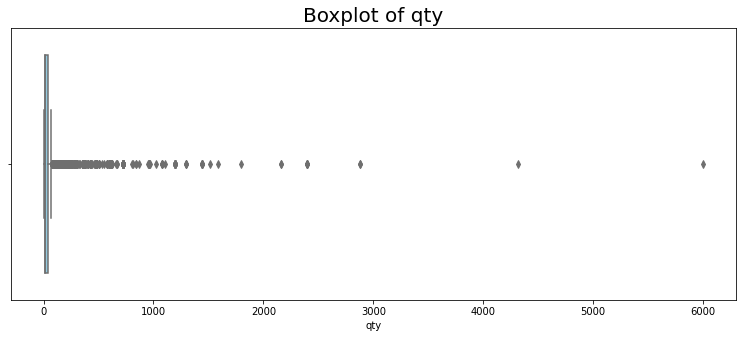

In [76]:
plot_freq(df, 'qty')

In [77]:
df.groupby('company')['item_description'].count()

company
ACE POWER PTE LTD                                 3
ACTIVE SOLUTION MARKETING PTE LTD                 1
AH HONG HOLDINGS PTE LTD                          9
ALPHA PIONEER ENTERPRISE PTE LTD                 29
AMAZON ASIA-PACIFIC HOLDINGS PRIVATE LIMITED     27
                                               ... 
WATSON'S PERSONAL CARE STORES PTE LTD           148
WE CANTEEN PTE LTD                               13
YEW LEONG MINI-MART                              89
YI XIN YUAN BEAUTY CARE                           4
ZHEN TAT ENTERPRISE                              96
Name: item_description, Length: 92, dtype: int64

In [78]:
df.groupby('company')['item_description'].nunique().sort_values().tail(20)

company
ELP STORE HOLLAND                      54
ELP STORE                              56
WALK-IN                                59
HENG ENG BOON SUPERMARTS PTE. LTD.     60
DJ.COM SCENTS & BEAUTY SHOP            63
PINK BEAUTY COSMETICS PTE. LTD.        64
SKYMART EXPRESS TRADING                64
R C COSMETICS HOUSE                    67
HABA PTE. LTD.                         69
DIAN ESSENTIALS                        70
OURLITTLEBASKET                        72
ZHEN TAT ENTERPRISE                    78
YEW LEONG MINI-MART                    85
MAYSON ESSENTIALS PTE. LTD.            86
CK DEPARTMENT STORE PTE LTD           104
ANN TENG HENG                         121
SUPER BUDGET STORE                    129
JJ BEAUTY HAIR & SKIN SOLUTIONS       131
SUNNY OCEAN PTE. LTD.                 196
RED TOMATOES (S) PTE LTD              201
Name: item_description, dtype: int64

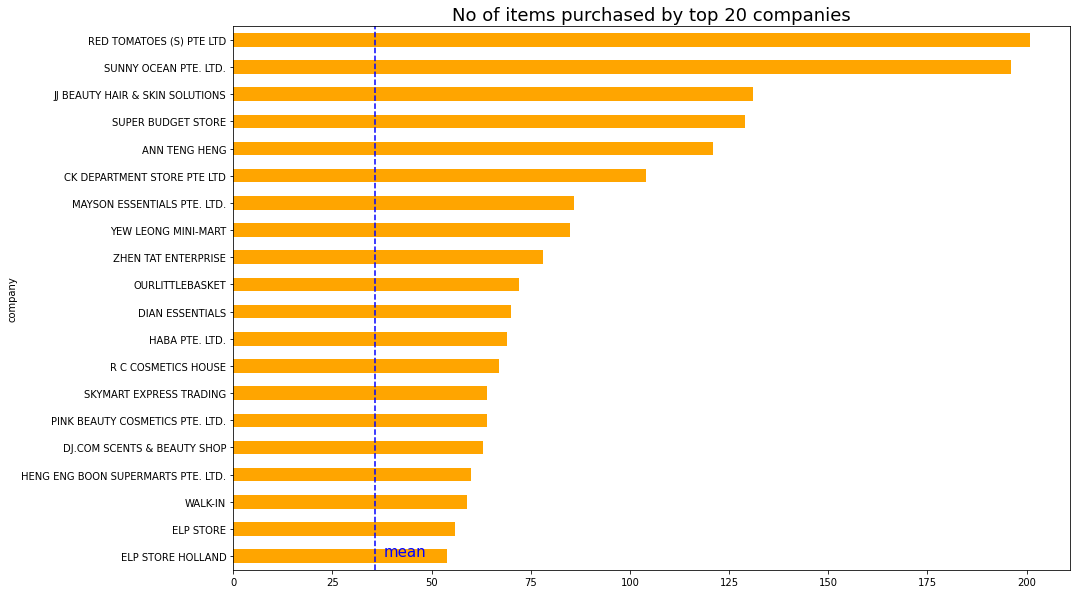

In [79]:
plt.figure(figsize=(15,10))
df.groupby('company')['item_description'].nunique().sort_values().tail(20).plot(kind='barh', color='orange');
plt.axvline(x=35.7,c='b',ls='--')
plt.title('No of items purchased by top 20 companies', fontsize=18);
plt.text(38,0,'mean',c='b',size=15);

In [80]:
df.groupby('company')['item_description'].nunique().describe()

count     92.000000
mean      35.706522
std       38.499190
min        1.000000
25%        8.000000
50%       23.000000
75%       48.000000
max      201.000000
Name: item_description, dtype: float64

In [81]:
df['qty'].describe()

count    5290.000000
mean       65.869943
std       202.550503
min         1.000000
25%        12.000000
50%        12.000000
75%        36.000000
max      6000.000000
Name: qty, dtype: float64

In [82]:
df[df['qty']>1000]['company'].unique()

array(['CHOP HONG HENG CORPORATION PTE LTD',
       'CK DEPARTMENT STORE PTE LTD', 'SKYMART EXPRESS TRADING',
       'SUNNY OCEAN PTE. LTD.', 'VELX MARKETING PTE LTD'], dtype=object)

In [83]:
df[df['qty']>1000]['item_description'].unique()

array(['Colgate Total 12 Charcoal Deep Clean 150g (1x72)',
       'Kirei-Kirei Handsoap AB+Antiseptic Agent Refill 200ml(White) (1x24) (TH)',
       'Kirei-Kirei Handsoap AB Refreshing Grape Refill 200ml(G) (1x24) (TH)',
       'Kirei-Kirei Handsoap AB Moist Peach Refill 200ml(P) (1x24) (TH)',
       'Shokubutsu B/W Refill Radiance Calming & Whitening',
       'Shokubutsu B/W Refill Radiance Brightening &',
       'Bigen Speedy Hair Color No.881 Natural Black',
       'Bigen Speedy Hair Color No.882 Brownish Black',
       'Bigen Speedy Hair Color No.883 Dark Brown (1x54)',
       'Bigen Speedy Hair Color No.884 Natural Brown',
       'Glade Air Freshener Solid Gel Fresh Berries 170g (1x12)',
       'Kao Toilet Bleach Lemon 500ml (1x12)',
       "Kao Magiclean Wiper Sheet Dry Refill 40's(1x12)",
       'Mama Lemon DWL (Natural Lemon) Refill 600ml (1 x 24)',
       'Mama Lemon DWL (lemon Gold)Refill 600ml(1x24)',
       'Mama Lemon DWL Citrus  Refill 600ml(1x24)',
       'Colgate Total 

The mean number of items purchased by a company is about 35. Red Tomatoes has the highest variety of items purchased with 201 unique products. The products which are bought in large quantity does not overlap with the products with high profit margin.

#### Profit Margin VS Quantity

The same item can be sold at different unit price depending on the quantity purchased. To increase sales revenue, we can either sell a large quantity at a low price, or a small quantity with high profit margin.

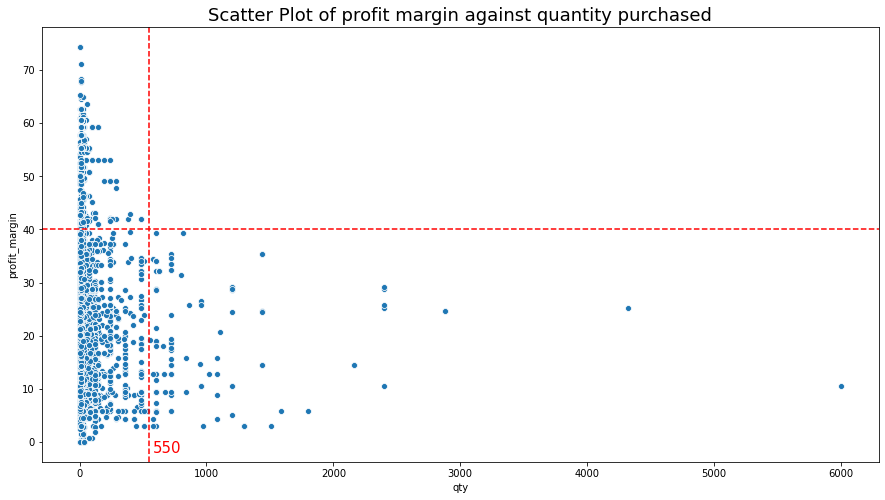

In [84]:
# Create a scatter plot of profit margin against quantity purchased
plt.figure(figsize=(15,8))
sns.scatterplot(data=df, x="qty", y="profit_margin")
plt.axhline(y=40,c='r',ls='--')
plt.axvline(x=550,c='r',ls='--')
plt.text(580,-2,'550',c='r',size=15)
plt.title('Scatter Plot of profit margin against quantity purchased', fontsize=18);

In [85]:
# Investigate one of the item with high profit margin
item = 'Kodomo Toothpaste Strawberry 80g(12/C)'

In [86]:
# Listing companies which purchased this item
df[df['item_description']==item][['company','item_description','profit_margin','qty']].drop_duplicates()

,company,item_description,profit_margin,qty
248,ANYA TRADING ENTERPRISE,Kodomo Toothpaste Strawberry 80g(12/C),57.83,12
481,BODY SENZE LLP,Kodomo Toothpaste Strawberry 80g(12/C),57.83,3
808,CONVENIENCE PLUS,Kodomo Toothpaste Strawberry 80g(12/C),57.83,12
1044,ELP STORE,Kodomo Toothpaste Strawberry 80g(12/C),57.83,12
1098,ELP STORE HOLLAND,Kodomo Toothpaste Strawberry 80g(12/C),57.86,12
1163,EZ HOME PRODUCTS PTE. LTD.,Kodomo Toothpaste Strawberry 80g(12/C),59.56,12
1366,FOOK CHOON WON KEE MEDICAL STORE,Kodomo Toothpaste Strawberry 80g(12/C),57.83,12
1501,HABA PTE. LTD.,Kodomo Toothpaste Strawberry 80g(12/C),57.83,6
1504,HABA PTE. LTD.,Kodomo Toothpaste Strawberry 80g(12/C),57.86,6
1720,HENG ENG BOON SUPERMARTS PTE. LTD.,Kodomo Toothpaste Strawberry 80g(12/C),57.83,12


The same item is sold at diferent unit price to different companies depending on the quantity purchased. As quantity increases, the unit price decreases and so does the profit margin. 

#### Frequency of sales by Different Categories

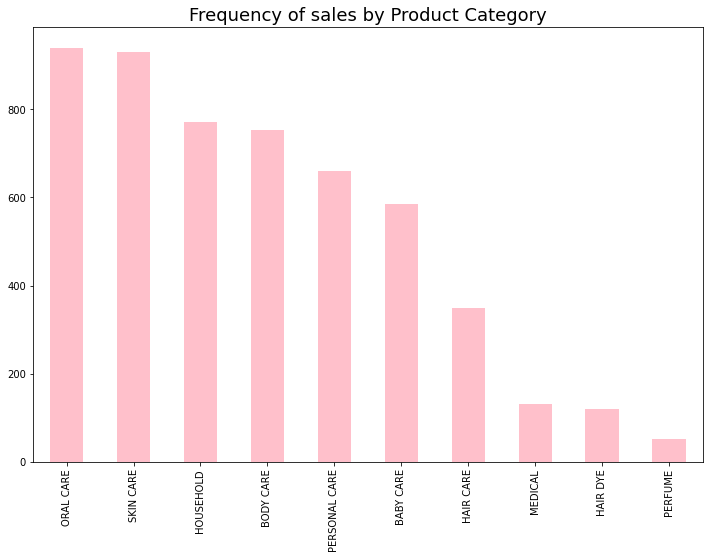

In [87]:
# Plot of frequency distribution of sales by category
plt.figure(figsize=(12,8))
df['category'].value_counts().plot(kind='bar', color='pink');
plt.title('Frequency of sales by Product Category', fontsize=18);

Fain Pte Ltd has highest sales in the two categories: Oral Care and Skin Care, followind by Household and Body Care. Medical, Hair Dye and Perfume are at the lower end. Coincidentally, they are considered to be dangerous goods and requires MSDS when doing importing of these items into Singapore.

#### Frequency of sales by Brands under Different Categories

In [88]:
df['category'].unique()

array(['BABY CARE', 'PERSONAL CARE', 'HOUSEHOLD', 'ORAL CARE', 'PERFUME',
       'BODY CARE', 'HAIR DYE', 'SKIN CARE', 'HAIR CARE', 'MEDICAL'],
      dtype=object)

In [89]:
# Creating subplot function to generate the frequency distribution of sales by brands under different categories
def plot_by_category(df, col_list):
    nrows = int(np.ceil(len(col_list)/2))
    fig, ax = plt.subplots(nrows=nrows, ncols=2, figsize=(15,nrows*6), sharey=False)
    ax = ax.ravel()
    plt.subplots_adjust(hspace=0.4)
    for i, column in enumerate(col_list):
        new_df = df[df['category']==column]
        new_df['brand'].value_counts().plot(kind='bar', color='pink',ax=ax[i]);
        ax[i].title.set_text('Frequency of sales by Brand under {}'.format(column))


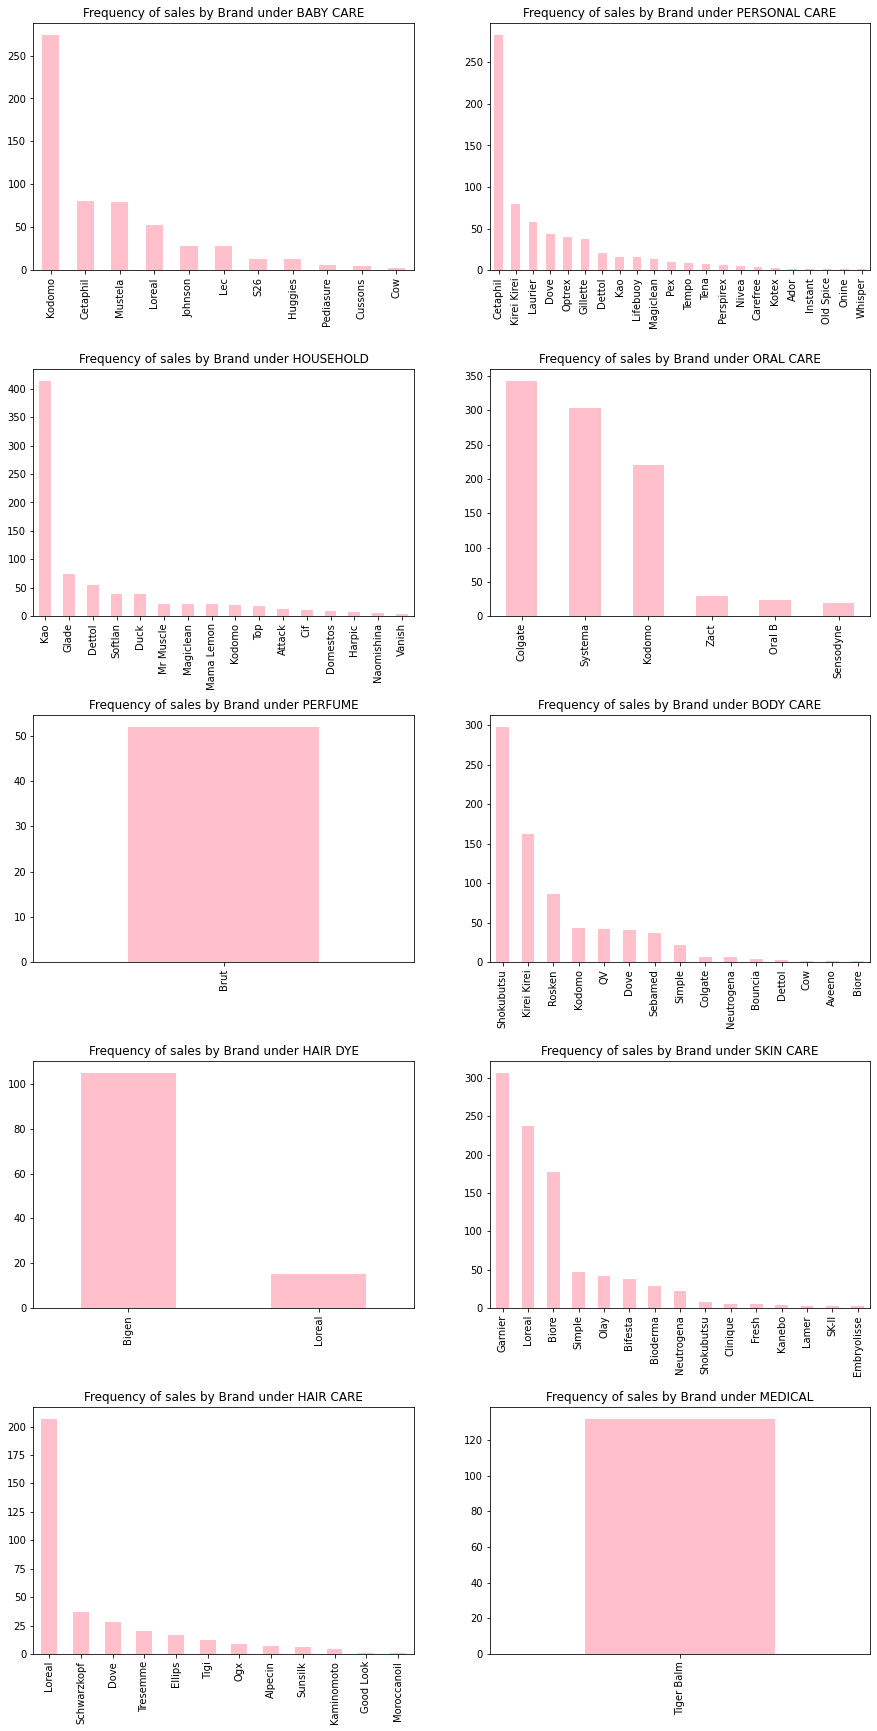

In [90]:
plot_by_category(df, df['category'].unique())

Certain brands like Kodomo, Cetaphil, Kao, Dettol etc appears in multiple categories. These brands produce multiple items. Kodomo is the most popular under Baby Care category, Cetaphil has the highest frequency of sales for Personal Care, highest sales for household is Kao, for Oral Care, Colgate has the highest sales records, Shokubutsu, Garnier and Loreal are the highest under Body Care, Skin Care and Hair Care respectively.

#### Frequency of sales by items Under different brands

In [91]:
# Creating a brand list for top brands under different category
brand_list = ['Cetaphil','Colgate','Kao','Systema','Shokubutsu','Garnier']

In [92]:
# Generating barplot for frequency of sales by items 
def plot_by_brand(df, col_list):
    nrows = int(np.ceil(len(col_list)))
    fig, ax = plt.subplots(nrows=nrows, ncols=1, figsize=(8,nrows*8), sharey=False)
    ax = ax.ravel()
    plt.subplots_adjust(hspace=0.2)
    for i, column in enumerate(col_list):
        new_df = df[df['brand']==column]
        new_df['item_description'].value_counts().sort_values().plot(kind='barh', color='skyblue',ax=ax[i]);
        ax[i].title.set_text('Frequency of sales by items under {}'.format(column))

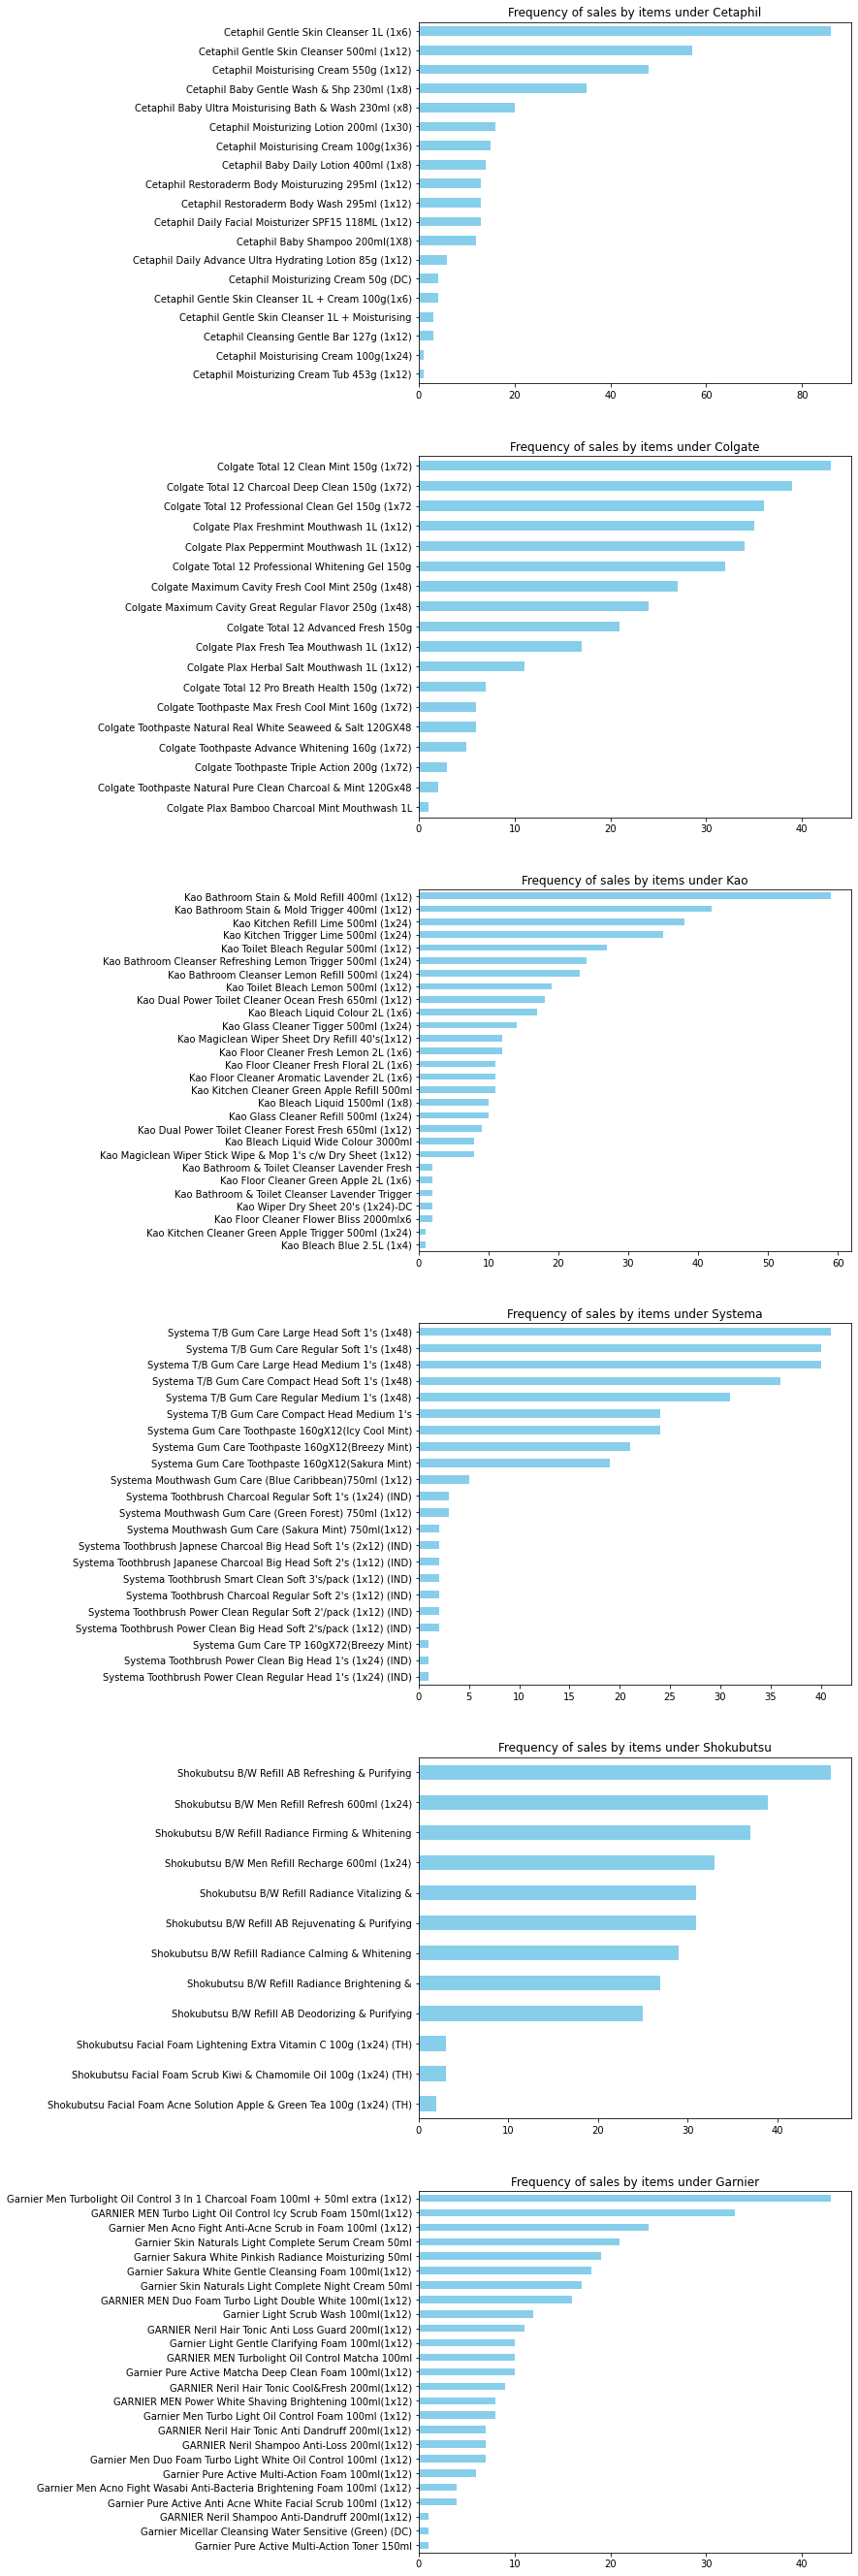

In [93]:
plot_by_brand(df, brand_list)

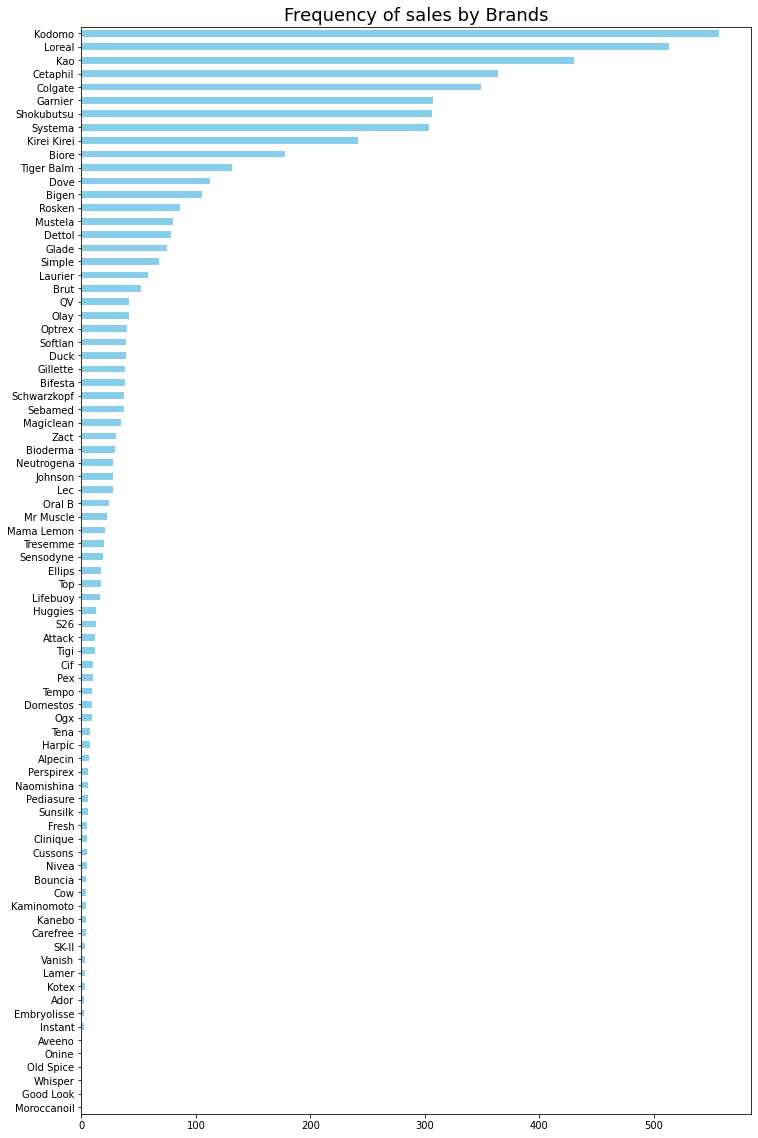

In [94]:
plt.figure(figsize=(12,20))
df['brand'].value_counts().sort_values().plot(kind='barh', color='skyblue');
plt.title('Frequency of sales by Brands', fontsize=18);

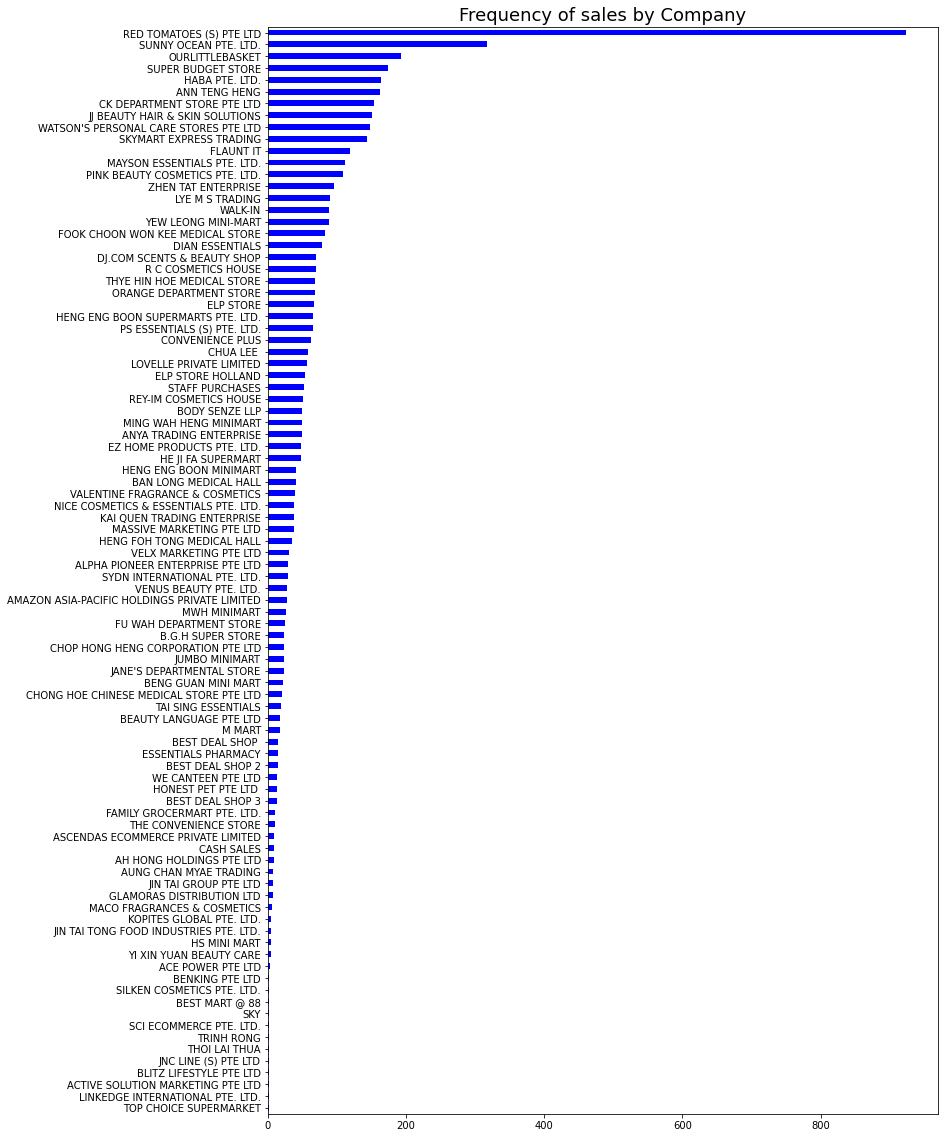

In [95]:
plt.figure(figsize=(12,20))
df['company'].value_counts().sort_values().plot(kind='barh', color='blue');
plt.title('Frequency of sales by Company', fontsize=18);

In [96]:
sales_by_brand = df.groupby('brand')['local_subtotal'].sum().sort_values(ascending=True)
sales_by_brand

brand
Instant            8.65
Good Look         28.80
Old Spice         48.00
Nivea             58.80
Onine             60.00
                ...    
Colgate        84099.51
Kao            92505.25
Shokubutsu     94050.88
Kodomo        112934.56
Cetaphil      188270.55
Name: local_subtotal, Length: 81, dtype: float64

In [97]:
df['brand'].nunique()

81

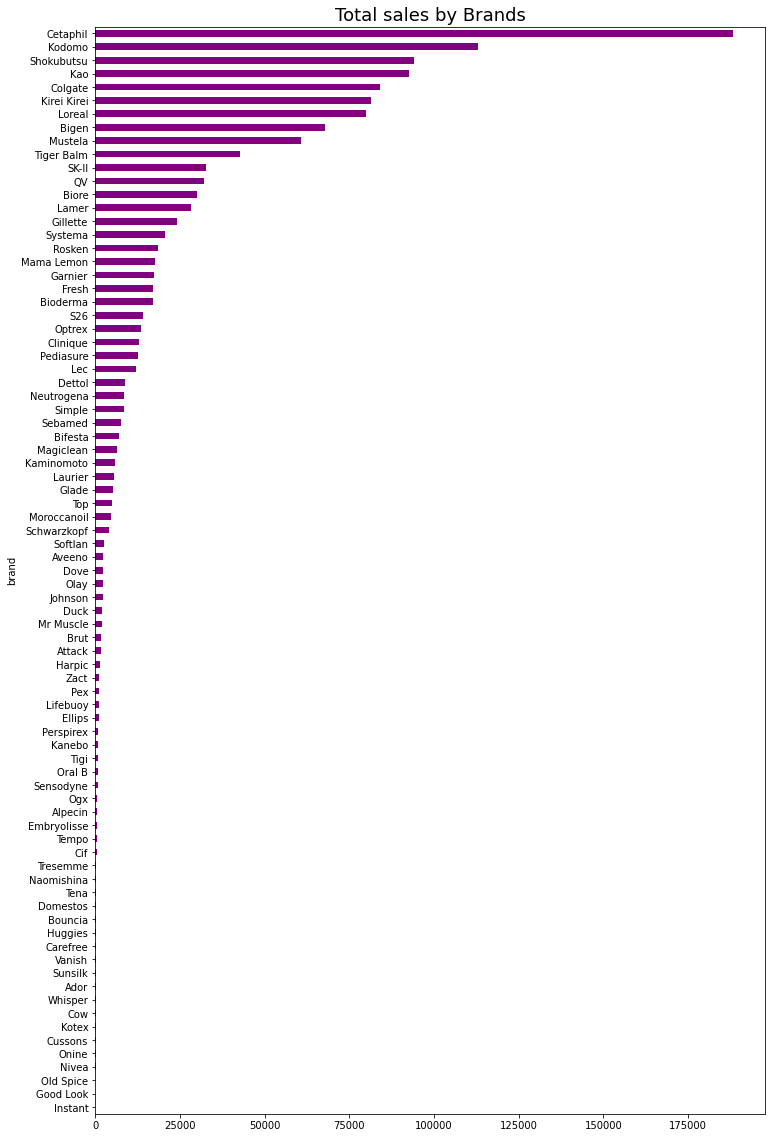

In [98]:
plt.figure(figsize=(12,20))
sales_by_brand.plot.barh(color='purple');
plt.title('Total sales by Brands', fontsize=18);

In [99]:
qty_by_brand = df.groupby('brand')['qty'].sum().sort_values(ascending=True)
qty_by_brand

brand
Instant            2
Onine              3
Good Look          6
Old Spice          6
Ador               8
               ...  
Kao            29463
Colgate        32657
Shokubutsu     35425
Kodomo         43446
Kirei Kirei    63955
Name: qty, Length: 81, dtype: int64

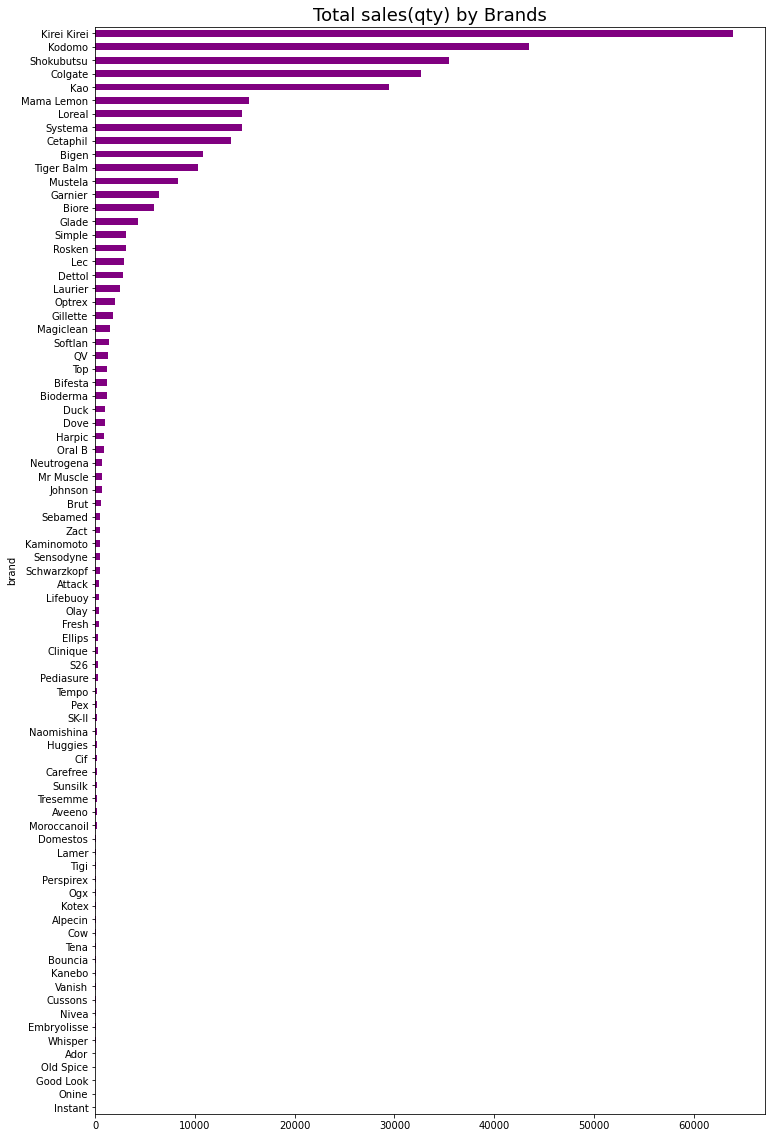

In [100]:
plt.figure(figsize=(12,20))
qty_by_brand.plot.barh(color='purple');
plt.title('Total sales(qty) by Brands', fontsize=18);

In [101]:
qty_by_item = df.groupby('item_description')['qty'].sum().sort_values(ascending=True).tail(20)
qty_by_item

item_description
Shokubutsu B/W Men Refill Recharge 600ml (1x24)                              3996
Shokubutsu B/W Refill AB Rejuvenating & Purifying                            4170
Shokubutsu B/W Men Refill Refresh 600ml (1x24)                               4260
Bigen Speedy Hair Color No.881 Natural Black                                 4320
Colgate Total 12 Professional Clean Gel 150g (1x72                           4675
Colgate Total 12 Professional Whitening Gel 150g                             4806
Shokubutsu B/W Refill Radiance Calming & Whitening                           4962
Shokubutsu B/W Refill Radiance Brightening &                                 5131
Shokubutsu B/W Refill AB Refreshing & Purifying                              5334
Kodomo Toothpaste Grape 80g(12/C)                                            5512
Kodomo Toothpaste Strawberry 80g(12/C)                                       5570
Colgate Total 12 Charcoal Deep Clean 150g (1x72)                             5856

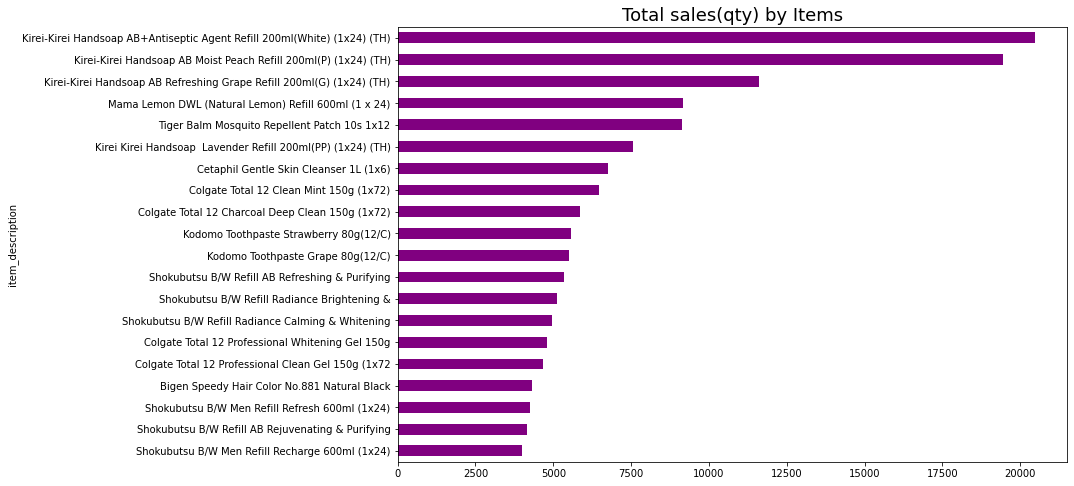

In [102]:
plt.figure(figsize=(12,8))
qty_by_item.plot.barh(color='purple');
plt.title('Total sales(qty) by Items', fontsize=18);

In [103]:
sales_by_item = df.groupby('item_description')['local_subtotal'].sum().sort_values(ascending=True).tail(30)
sales_by_item

item_description
Kodomo Laundry Softener Sweetie Care 3000ML (TH) (1x4)                       11073.30
Shokubutsu B/W Refill AB Rejuvenating & Purifying                            11093.52
Kodomo Bath Rice+Milk 1L (1x12)                                              11119.32
Shokubutsu B/W Men Refill Refresh 600ml (1x24)                               11353.56
SK-II Facial Treatment Essence 230ml                                         11648.00
Cetaphil Baby Gentle Wash & Shp 230ml (1x8)                                  12221.60
PEDIASURE MILK POWDER VANILA 1.6KG X 6PCS                                    12660.00
Kirei-Kirei Handsoap AB Refreshing Grape Refill 200ml(G) (1x24) (TH)         12731.22
Shokubutsu B/W Refill Radiance Calming & Whitening                           13052.04
Lamer The Eye Concentrate l]                                             13120.00
Bigen Speedy Hair Color No.883 Dark Brown (1x54)                             13243.00
Colgate Total 12 Charcoal Deep Clean 150g

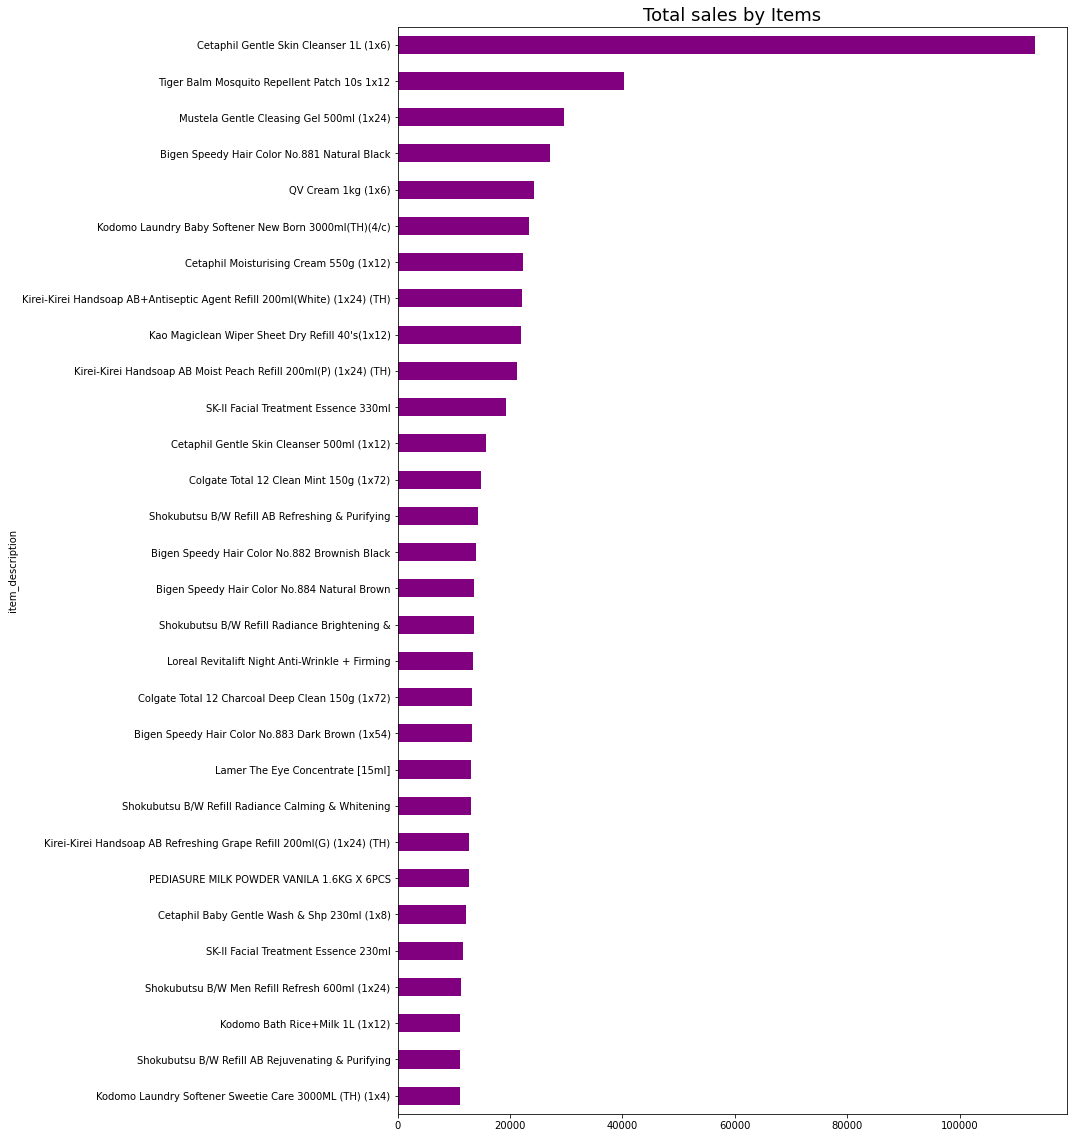

In [104]:
plt.figure(figsize=(12,20))
sales_by_item.plot.barh(color='purple');
plt.title('Total sales by Items', fontsize=18);

In [105]:
sales_by_company = df.groupby('company')['local_subtotal'].sum().sort_values(ascending=True).tail(20)
sales_by_company

company
ZHEN TAT ENTERPRISE                         9783.80
ORANGE DEPARTMENT STORE                    10079.90
HABA PTE. LTD.                             10828.30
JIN TAI TONG FOOD INDUSTRIES PTE. LTD.     11064.00
CHOP HONG HENG CORPORATION PTE LTD         11653.20
REY-IM COSMETICS HOUSE                     11813.88
BEAUTY LANGUAGE PTE LTD                    13252.44
ALPHA PIONEER ENTERPRISE PTE LTD           19124.80
VENUS BEAUTY PTE. LTD.                     20485.32
PINK BEAUTY COSMETICS PTE. LTD.            28232.88
LYE M S TRADING                            28396.28
VELX MARKETING PTE LTD                     35478.60
SKYMART EXPRESS TRADING                    38088.90
MASSIVE MARKETING PTE LTD                  42113.52
OURLITTLEBASKET                            70076.42
SUNNY OCEAN PTE. LTD.                     106020.94
WATSON'S PERSONAL CARE STORES PTE LTD     138528.43
RED TOMATOES (S) PTE LTD                  145077.54
FLAUNT IT                                 159818.72
CK D

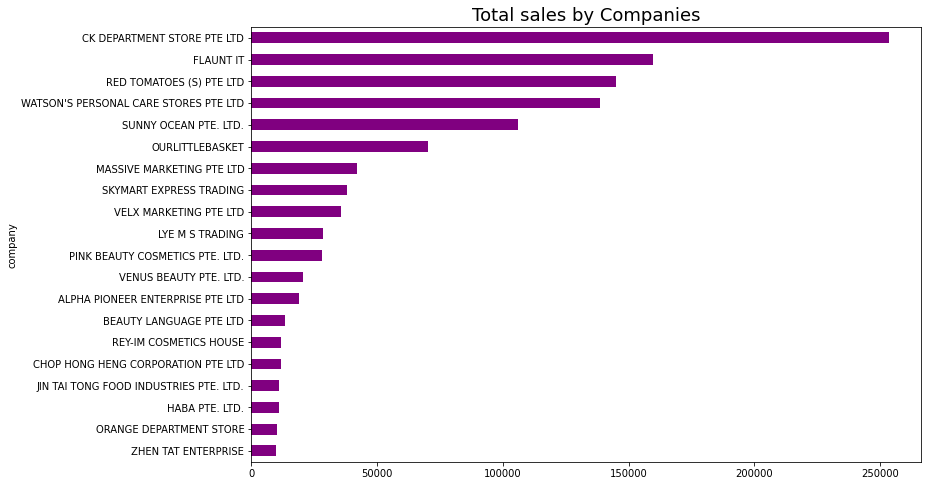

In [106]:
plt.figure(figsize=(12,8))
sales_by_company.plot.barh(color='purple');
plt.title('Total sales by Companies', fontsize=18);

In [107]:
df['count_7'] = df['local_sub_total_7'].map(lambda x: 0 if x==0.0 else 1)
df['count_8'] = df['local_sub_total_8'].map(lambda x: 0 if x==0.0 else 1)
df['count_9'] = df['local_sub_total_9'].map(lambda x: 0 if x==0.0 else 1)

In [108]:
df['count_total'] = df['count_7'] + df['count_8'] + df['count_9']

In [109]:
df.head(3)

,company,category,brand,invoice_no,item_code,item_description,local_sub_total_7,local_sub_total_8,local_sub_total_9,unit_cost_7,...,qty,unit_price,local_total_cost,extracted_qty,extracted_size,size,count_7,count_8,count_9,count_total
0,ACE POWER PTE LTD,BABY CARE,Loreal,INV-20000010,5.011408e+12,Loreal Kids Shampoo Strawberry 250ml (1x6),326.4,0.0,0.0,2.75,...,102,3.2,280.5000,"[250ml, 1x6]",250ml,small,1,0,0,1
1,ACE POWER PTE LTD,BABY CARE,Loreal,INV-20000381,3.600520e+12,Loreal Kids Conditioner Strawberry 250ml (1x6),0.0,268.8,0.0,0.00,...,84,3.2,242.4545,"[250ml, 1x6]",250ml,small,0,1,0,1
2,ACE POWER PTE LTD,BABY CARE,Loreal,INV-20000490,3.600520e+12,Loreal Kids Conditioner Strawberry 250ml (1x6),0.0,268.8,0.0,0.00,...,84,3.2,243.5411,"[250ml, 1x6]",250ml,small,0,1,0,1


In [110]:
df[df['count_total']==0]

,company,category,brand,invoice_no,item_code,item_description,local_sub_total_7,local_sub_total_8,local_sub_total_9,unit_cost_7,...,qty,unit_price,local_total_cost,extracted_qty,extracted_size,size,count_7,count_8,count_9,count_total


In [111]:
def get_company(df, company):
    
    company_df  = df.loc[df['company']==company,:]
    col = ['local_sub_total_7','local_sub_total_8','local_sub_total_9']
    month = ['July','August',"September"]
    print('Company : {}'.format(company))
    for c in range(len(col)):
        print('Sales in {} : {}'.format(month[c], round(company_df[col[c]].sum(),2)))

    a = company_df.groupby('item_description')['local_subtotal'].sum().sort_values(ascending=True)
    b = company_df.groupby('item_description')['qty'].sum().sort_values(ascending=True)
    c = company_df.groupby('item_description')['profit_margin'].mean().sort_values(ascending=True)
    a.to_frame().reset_index()
    b.to_frame().reset_index()
    c.to_frame().reset_index()
    
    new_df = pd.merge(b, c, on='item_description')
    new_df = pd.merge(new_df, a, on='item_description')
    new_df['profit_margin']=new_df['profit_margin'].map(lambda x: round(x,2))
    return new_df

In [112]:
company = 'PINK BEAUTY COSMETICS PTE. LTD.'
pink_beauty = get_company(df, company)

Company : PINK BEAUTY COSMETICS PTE. LTD.
Sales in July : 14385.86
Sales in August : 10625.02
Sales in September : 3222.0


In [113]:
pink_beauty

,qty,profit_margin,local_subtotal
item_description,,,
Biore UV Perfect Bright Milk SPF50+ 30ml (1x24),12,44.00,114.0
Biore Micellar Cleansing Water 300ml (1x12),12,23.09,159.0
Laurier F Ultra Gentle Night 35cm 8's (1x16),18,16.27,67.5
KIREI-KIREI BODY SOAP REFRESHING GRAPE 600MLX24,18,12.46,71.1
Loreal White Perfect Toner 200ml,23,29.24,105.8
...,...,...,...
Colgate Total 12 Professional Clean Gel 150g (1x72,432,21.60,1080.0
Colgate Total 12 Professional Whitening Gel 150g,504,21.60,1260.0
Shokubutsu B/W Refill AB Refreshing & Purifying,552,12.73,1518.0


In [114]:
item_1 = 'KIREI-KIREI BODY SOAP REFRESHING GRAPE 600MLX24'
item_2 = 'Shokubutsu B/W Refill AB Refreshing & Purifying'

In [115]:
red_tomatoes = get_company(df, 'RED TOMATOES (S) PTE LTD')

Company : RED TOMATOES (S) PTE LTD
Sales in July : 54389.91
Sales in August : 59728.92
Sales in September : 30958.71


In [116]:
red_tomatoes

,qty,profit_margin,local_subtotal
item_description,,,
Colgate Plax Bamboo Charcoal Mint Mouthwash 1L,3,24.30,16.05
Loreal Excellence Fashion #6.35 Intense Copper Brown (1x12),3,35.58,21.60
Loreal Excellence Creme #5.35 Chocolate Brown,3,35.58,21.60
Bifesta Cleansing Lotion Acne Care 300ml,6,17.35,41.16
Biore UV Perfect Bright Milk SPF50+ 30ml (1x24),6,44.00,57.00
...,...,...,...
Laurier Double Comfort Day Non Wing 22cm 28's (1x2,846,36.98,923.94
Kirei-Kirei Handsoap AB Refreshing Grape Refill 200ml(G) (1x24) (TH),1824,25.45,1915.20
Cetaphil Gentle Skin Cleanser 1L (1x6),2988,5.88,50796.00


## Recommender Systems

We will be building five recommender systems and compare the results generated. The five systems are popularity model, content based filtering, user-based collaborative filtering, collaborative filtering with Singular Values Decomposition and Hybrid Model.

## Popularity Model
[top](#Contents)

The popularity model is a very basic but important model as it simply recommends the most popular items to a user. This method has been traditionally deployed by business owners when they wish to upsell their other products.

In [117]:
#Computes the most popular items
popularity_df = df.groupby('item_description')['qty'].sum().sort_values(ascending=False).reset_index()
popularity_df.head(10)

,item_description,qty
0,Kirei-Kirei Handsoap AB+Antiseptic Agent Refil...,20486
1,Kirei-Kirei Handsoap AB Moist Peach Refill 200...,19462
2,Kirei-Kirei Handsoap AB Refreshing Grape Refil...,11604
3,Mama Lemon DWL (Natural Lemon) Refill 600ml (1...,9168
4,Tiger Balm Mosquito Repellent Patch 10s 1x12,9120
5,Kirei Kirei Handsoap Lavender Refill 200ml(PP...,7560
6,Cetaphil Gentle Skin Cleanser 1L (1x6),6752
7,Colgate Total 12 Clean Mint 150g (1x72),6474
8,Colgate Total 12 Charcoal Deep Clean 150g (1x72),5856
9,Kodomo Toothpaste Strawberry 80g(12/C),5570


In [118]:
class PopularityRecommender:
    
    MODEL_NAME = 'Popularity'
    
    def __init__(self, popularity_df, items_df=None):
        self.popularity_df = popularity_df
        self.items_df = items_df

        
    def recommend_items(self, user_id, items_to_ignore=[], topn=10, verbose=False):
        # Recommend the more popular items that the user hasn't seen yet.
        recommendations_df = self.popularity_df[~self.popularity_df['item_description'].isin(items_to_ignore)] \
                               .sort_values('qty', ascending = False) \
                               .head(topn)

        if verbose:
            if self.items_df is None:
                raise Exception('"items_df" is required in verbose mode')

            recommendations_df = recommendations_df.merge(self.items_df, how = 'left', 
                                                          left_on = 'item_description', 
                                                          right_on = 'item_description')[['qty', 'item_description', 'profit_margin']]


        return recommendations_df
    
popularity_model = PopularityRecommender(popularity_df, df)

In [119]:
# getting items that Pink Beauty has purchased
items_to_ignore = pink_beauty.index

In [120]:
items_to_ignore[:10]

Index(['Biore UV Perfect Bright Milk SPF50+ 30ml (1x24)',
       'Biore Micellar Cleansing Water 300ml (1x12)',
       'Laurier F Ultra Gentle Night 35cm 8's (1x16)',
       'KIREI-KIREI BODY SOAP REFRESHING GRAPE 600MLX24',
       'Loreal White Perfect Toner 200ml',
       'KIREI-KIREI BODY SOAP NOURISHING BERRIES 600MLX24',
       'Kodomo Soft&Slim Toothbrush(Age 3-5Yrs)',
       'Kodomo Soft&Slim Toothbrush(Age0.5-2YRS)',
       'Biore UV Perfect Milk SPF50 40ml (1x24)',
       'KIREI-KIREI BODY SOAP NATURAL CITRUS 600MLX24'],
      dtype='object', name='item_description')

In [121]:
# returning top items that Pink Beauty has not purchased before
popularity_model.recommend_items(company, items_to_ignore=[items_to_ignore])

,item_description,qty
0,Kirei-Kirei Handsoap AB+Antiseptic Agent Refil...,20486
1,Kirei-Kirei Handsoap AB Moist Peach Refill 200...,19462
2,Kirei-Kirei Handsoap AB Refreshing Grape Refil...,11604
3,Mama Lemon DWL (Natural Lemon) Refill 600ml (1...,9168
4,Tiger Balm Mosquito Repellent Patch 10s 1x12,9120
5,Kirei Kirei Handsoap Lavender Refill 200ml(PP...,7560
6,Cetaphil Gentle Skin Cleanser 1L (1x6),6752
7,Colgate Total 12 Clean Mint 150g (1x72),6474
8,Colgate Total 12 Charcoal Deep Clean 150g (1x72),5856
9,Kodomo Toothpaste Strawberry 80g(12/C),5570


In [122]:
# Cross-checking items to ignore
pink_beauty.index

Index(['Biore UV Perfect Bright Milk SPF50+ 30ml (1x24)',
       'Biore Micellar Cleansing Water 300ml (1x12)',
       'Laurier F Ultra Gentle Night 35cm 8's (1x16)',
       'KIREI-KIREI BODY SOAP REFRESHING GRAPE 600MLX24',
       'Loreal White Perfect Toner 200ml',
       'KIREI-KIREI BODY SOAP NOURISHING BERRIES 600MLX24',
       'Kodomo Soft&Slim Toothbrush(Age 3-5Yrs)',
       'Kodomo Soft&Slim Toothbrush(Age0.5-2YRS)',
       'Biore UV Perfect Milk SPF50 40ml (1x24)',
       'KIREI-KIREI BODY SOAP NATURAL CITRUS 600MLX24',
       'Kodomo Soft&Slim Toothbrush(Age9-12Yrs)',
       'Biore UV Aqua Rich Watery Essence SPF50 50g (1x24)',
       'Laurier F Ultra Gentle Night 40cm 7's (1x16)',
       'Kodomo Pro Toothbrush(Age0.5-3YRS)',
       'Kodomo Soft&Slim Toothbrush (Age6-9) 1x48',
       'Kodomo Pro Toothbrush(Age9-12YRS)',
       'Biore Men D/Acne Ctrl Foam Wash 150ml(1x24)',
       'Rosken Dry Skin Lotion with Vitamin E 75ml (1x24)',
       'Rosken Skin Repair Dry Skin Cream 75

In [123]:
#Computes the most popular items
margin_df = df.groupby('item_description')['profit_margin'].mean().sort_values(ascending=False).reset_index()
margin_df.head(10)

,item_description,profit_margin
0,Systema Mouthwash Gum Care (Sakura Mint) 750ml...,74.400000
1,Kodomo Softener Refill 600ml (TH) (1x12),62.264444
2,Systema Gum Care Toothpaste 160gX12(Breezy Mint),60.819524
3,Systema Gum Care Toothpaste 160gX12(Icy Cool M...,60.805000
4,Systema Gum Care Toothpaste 160gX12(Sakura Mint),60.465789
5,Systema T/B Gum Care Large Head Soft 1's (1x48),58.571463
6,Systema T/B Gum Care Large Head Medium 1's (1x48),58.422750
7,Systema T/B Gum Care Regular Medium 1's (1x48),58.241613
8,Systema T/B Gum Care Compact Head Soft 1's (1x48),57.806111
9,Systema T/B Gum Care Compact Head Medium 1's,57.685417


In [124]:
# Defining a function to list profit margin for recommended items
def popularity_rec(df, item):
    print('Item : {}'.format(item))
    p = round(margin_df[margin_df['item_description']==item]['profit_margin'].item(),2)
    print('Profit Margin : {}%'.format(p))
    q = df[df.index==item]['qty'].item()
    print('Qty Purchsed : {}'.format(q))
    print('')
    a = popularity_model.recommend_items(company, items_to_ignore=[items_to_ignore])
    
    item_rec = pd.merge(a,margin_df, on='item_description', how='inner')
    item_rec['profit_margin'] = round(item_rec['profit_margin'],1)
    
    return item_rec

In [125]:
# Shows the top 10 items recommended by the popularity model
popularity_rec(pink_beauty, item_1)

Item : KIREI-KIREI BODY SOAP REFRESHING GRAPE 600MLX24
Profit Margin : 10.46%
Qty Purchsed : 18



,item_description,qty,profit_margin
0,Kirei-Kirei Handsoap AB+Antiseptic Agent Refil...,20486,28.1
1,Kirei-Kirei Handsoap AB Moist Peach Refill 200...,19462,28.9
2,Kirei-Kirei Handsoap AB Refreshing Grape Refil...,11604,28.4
3,Mama Lemon DWL (Natural Lemon) Refill 600ml (1...,9168,12.7
4,Tiger Balm Mosquito Repellent Patch 10s 1x12,9120,27.0
5,Kirei Kirei Handsoap Lavender Refill 200ml(PP...,7560,30.7
6,Cetaphil Gentle Skin Cleanser 1L (1x6),6752,6.3
7,Colgate Total 12 Clean Mint 150g (1x72),6474,18.5
8,Colgate Total 12 Charcoal Deep Clean 150g (1x72),5856,17.7
9,Kodomo Toothpaste Strawberry 80g(12/C),5570,48.2


In the popularity model, the system recommends the top 10 most popular items that PINK BEAUTY has not purchased before. This simple model suggests items that are in trend or bought in large quantities by other retailers. It is easy to implement but lacks personalization. It is useful when we do not have good understanding about users' behaviour or preferences.

### Content Based Filtering


[top](#Contents)

Content based filtering model uses items features to identify similar items that user has purchased before. To obtain the item features, we will use the category column of our original dataframe. To create more item features from the item description column, we have extracted the size information using regex as well as sub-categories using count vectorizer as shown in the earlier sections. 

In [126]:
# Define a function to create dataframe for columns as item features
def create_features_df(df, col):
    
    # creating a dataframe for categories
    features_df = df.groupby(["item_description", col]).size().sort_values(ascending=False).unstack().fillna(0)
    
    
    for col in features_df.columns:
        features_df[col] = features_df[col].map(lambda x: 0 if x==0.0 else 1)
    
    return features_df

In [127]:
size_df = create_features_df(df, 'size')
size_df

size,large,medium,mini,nil,small,x-large
item_description,,,,,,
Ador Disposal Mask (50pcs/box) 1x40,0,0,0,1,0,0
Alpecin Caffeine Shampoo 250ml (1x6),0,0,0,0,1,0
Attack Detergent Powder 3KG (1x6),0,0,0,0,0,1
Attack Liquid Detergent + Softener 3600gx3 (1x3),0,0,0,0,0,1
Attack Liquid Detergent + Softener Refill 1400gx8 (1x8),1,0,0,0,0,0
...,...,...,...,...,...,...
Vinda Tissue Box Blue 6 Boxes/pack (1x10),0,0,0,1,0,0
Vinda Toilet Roll 10roll x3ply 1800G (1x6),0,0,0,1,0,0
Whisper Regular Flow Wing 40's (12x40's),0,0,0,1,0,0


In [128]:
# Create a dataframe to store the categories as item features
cat_df = create_features_df(df, 'category')
cat_df

category,BABY CARE,BODY CARE,HAIR CARE,HAIR DYE,HOUSEHOLD,MEDICAL,ORAL CARE,PERFUME,PERSONAL CARE,SKIN CARE
item_description,,,,,,,,,,
Ador Disposal Mask (50pcs/box) 1x40,0,0,0,0,0,0,0,0,1,0
Alpecin Caffeine Shampoo 250ml (1x6),0,0,1,0,0,0,0,0,0,0
Attack Detergent Powder 3KG (1x6),0,0,0,0,1,0,0,0,0,0
Attack Liquid Detergent + Softener 3600gx3 (1x3),0,0,0,0,1,0,0,0,0,0
Attack Liquid Detergent + Softener Refill 1400gx8 (1x8),0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
Vinda Tissue Box Blue 6 Boxes/pack (1x10),0,0,0,0,0,0,0,0,1,0
Vinda Toilet Roll 10roll x3ply 1800G (1x6),0,0,0,0,0,0,0,0,1,0
Whisper Regular Flow Wing 40's (12x40's),0,0,0,0,0,0,0,0,1,0


In [129]:
# To display the dataframe containing sub-categories as item features
content_df

,skin,care,gentle,cream,baby,men,gum,hair,wash,cleanser,...,scrub,laundry,toothbrush,bleach,kitchen,firming,hand,eye,soap,moisturizing
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5285,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
5286,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5287,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5288,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [130]:
# Reset index in running order for df
df.reset_index(drop=True, inplace=True)

In [131]:
df['item_description']

0              Loreal Kids Shampoo Strawberry 250ml (1x6)
1          Loreal Kids Conditioner Strawberry 250ml (1x6)
2          Loreal Kids Conditioner Strawberry 250ml (1x6)
3                 PEX Active Hand Sanitizer 500Ml (1x 24)
4               PEDIASURE MILK POWDER VANILA 1.6KG X 6PCS
                              ...                        
5285        Neutrogena Clear & Defend Facial Wash 200MLx6
5286      Olay Cleanse Facial Cleansing Toner 200ml (1x6)
5287      Olay Cleanse Make-up Cleansing Milk 200ml (1x6)
5288    Olay Cleanse Facial Foaming Cleansing Jelly 15...
5289            Simple Soothing Facial Toner 200ml (1x36)
Name: item_description, Length: 5290, dtype: object

In [132]:
item_df = df['item_description'].to_frame()
item_df

,item_description
0,Loreal Kids Shampoo Strawberry 250ml (1x6)
1,Loreal Kids Conditioner Strawberry 250ml (1x6)
2,Loreal Kids Conditioner Strawberry 250ml (1x6)
3,PEX Active Hand Sanitizer 500Ml (1x 24)
4,PEDIASURE MILK POWDER VANILA 1.6KG X 6PCS
...,...
5285,Neutrogena Clear & Defend Facial Wash 200MLx6
5286,Olay Cleanse Facial Cleansing Toner 200ml (1x6)
5287,Olay Cleanse Make-up Cleansing Milk 200ml (1x6)
5288,Olay Cleanse Facial Foaming Cleansing Jelly 15...


In [133]:
# combining the items features and match it to the respective item_description
content_df = pd.concat([item_df, content_df], axis=1)
content_df.head(3)

,item_description,skin,care,gentle,cream,baby,men,gum,hair,wash,...,scrub,laundry,toothbrush,bleach,kitchen,firming,hand,eye,soap,moisturizing
0,Loreal Kids Shampoo Strawberry 250ml (1x6),0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Loreal Kids Conditioner Strawberry 250ml (1x6),0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Loreal Kids Conditioner Strawberry 250ml (1x6),0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [134]:
content_df.drop_duplicates(inplace=True)

In [135]:
content_df.head()

,item_description,skin,care,gentle,cream,baby,men,gum,hair,wash,...,scrub,laundry,toothbrush,bleach,kitchen,firming,hand,eye,soap,moisturizing
0,Loreal Kids Shampoo Strawberry 250ml (1x6),0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Loreal Kids Conditioner Strawberry 250ml (1x6),0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,PEX Active Hand Sanitizer 500Ml (1x 24),0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
4,PEDIASURE MILK POWDER VANILA 1.6KG X 6PCS,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,Dettol Spray Neutra Air Revitalising Fresh Bre...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [136]:
print(content_df.shape, cat_df.shape)

(528, 43) (528, 10)


In [137]:
# Storing and combining all item features into one dataframe
features_df = pd.merge(cat_df, size_df, on=['item_description'])

In [138]:
features_df = pd.merge(features_df, content_df, on=['item_description'])

In [139]:
features_df.shape

(528, 59)

In [140]:
features_df.head()

,item_description,BABY CARE,BODY CARE,HAIR CARE,HAIR DYE,HOUSEHOLD,MEDICAL,ORAL CARE,PERFUME,PERSONAL CARE,...,scrub,laundry,toothbrush,bleach,kitchen,firming,hand,eye,soap,moisturizing
0,Ador Disposal Mask (50pcs/box) 1x40,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,Alpecin Caffeine Shampoo 250ml (1x6),0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Attack Detergent Powder 3KG (1x6),0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Attack Liquid Detergent + Softener 3600gx3 (1x3),0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Attack Liquid Detergent + Softener Refill 1400...,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [141]:
features_df.set_index('item_description', inplace=True)

In [142]:
# Dropping the nil column which is not wanted as item feature
features_df.drop('nil', axis=1, inplace=True)

In [143]:
features_df.shape

(528, 57)

In [144]:
# creating a similarity matrix for items based on features
item_sim = pd.DataFrame(
    cosine_similarity(features_df),
    columns=features_df.index,
    index=features_df.index
)

In [145]:
item_sim.shape

(528, 528)

In [146]:
item_sim.head()

item_description,Ador Disposal Mask (50pcs/box) 1x40,Alpecin Caffeine Shampoo 250ml (1x6),Attack Detergent Powder 3KG (1x6),Attack Liquid Detergent + Softener 3600gx3 (1x3),Attack Liquid Detergent + Softener Refill 1400gx8 (1x8),Attack Liquid Detergent Floral Perfume Refill 1400gx8 (1x8),Attack Liquid Detergent Ultra Perfume Refill 1600gx8 (1x8),Attack Liquid Detergent Ultra Power 4000gx3 (1x3),Attack Powder Detergent + Softener 2800gx3 (1x3),Aveeno Daily Moisturising Lotion 1L (1x6),...,Top Nanox Liq Detergent Ultra Concentrated Deo Bright 450g (1x15),Top Nanox Liq Detergent Ultra Deo Bright Refill 360g (1x24),Tresemme Hair 7-in-1 Primer Cream Biotin+ Repair 7 125ml (1x6),Tresemme Hair Mist Spray Hydrating Detangling125ml (1x6),Vanish Liquid Stain Remover 1L (1x12) (IND),Vinda Tissue Box Blue 6 Boxes/pack (1x10),Vinda Toilet Roll 10roll x3ply 1800G (1x6),Whisper Regular Flow Wing 40's (12x40's),ZACT Smokers Toothpaste 150gX72,ZACT Whitening Toothpaste 150gX72
item_description,,,,,,,,,,,,,,,,,,,,,
Ador Disposal Mask (50pcs/box) 1x40,1.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,...,0.000000,0.000000,0.00000,0.00000,0.000000,1.0,0.707107,1.0,0.000000,0.000000
Alpecin Caffeine Shampoo 250ml (1x6),0.0,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,...,0.000000,0.408248,0.57735,0.57735,0.000000,0.0,0.000000,0.0,0.333333,0.288675
Attack Detergent Powder 3KG (1x6),0.0,0.0,1.000000,0.707107,0.353553,0.408248,0.408248,0.816497,0.408248,0.00,...,0.707107,0.500000,0.00000,0.00000,0.408248,0.0,0.000000,0.0,0.000000,0.000000
Attack Liquid Detergent + Softener 3600gx3 (1x3),0.0,0.0,0.707107,1.000000,0.750000,0.577350,0.577350,0.866025,0.577350,0.00,...,0.500000,0.353553,0.00000,0.00000,0.577350,0.0,0.000000,0.0,0.000000,0.000000
Attack Liquid Detergent + Softener Refill 1400gx8 (1x8),0.0,0.0,0.353553,0.750000,1.000000,0.866025,0.866025,0.577350,0.866025,0.25,...,0.500000,0.353553,0.00000,0.00000,0.866025,0.0,0.000000,0.0,0.000000,0.000000


In [147]:
# Looking at the top 10 recommended items for item_1
item_sim[item_1].sort_values(ascending=False).head(10)

item_description
Kirei Kire Body Soap Refreshing Grape AB Refill(G) 600ml (1x12) (TH)    1.000000
Kirei Kirei Body Soap Natural Citrus Refill AB (Y) 600ml (1x12) (TH)    1.000000
Cow Milky Body Soap Yuzu Refill 400ML                                   1.000000
KIREI-KIREI BODY SOAP REFRESHING GRAPE 600MLX24                         1.000000
KIREI-KIREI BODY SOAP NATURAL CITRUS 600MLX24                           1.000000
KIREI-KIREI BODY SOAP NOURISHING BERRIES 600MLX24                       1.000000
BOUNCIA BODY SOAP (AIRY BOUQUET ) REFILL 400ML                          1.000000
BOUNCIA BODY SOAP (WHITE SOAP) REFILL 400ML                             0.944911
Bouncia Body Soap (White Soap) Pump 500ml (1x12)                        0.944911
KIREI-KIREI BODY SOAP MOISTURIZING PEACH 600MLX24                       0.894427
Name: KIREI-KIREI BODY SOAP REFRESHING GRAPE 600MLX24, dtype: float64

In [148]:
# Looking at the top 10 recommended items for item_2
item_sim[item_2].sort_values(ascending=False).head(10)

item_description
Shokubutsu B/W Refill AB Deodorizing & Purifying                  1.000000
Shokubutsu B/W Refill Radiance Vitalizing &                       1.000000
Shokubutsu B/W Refill Radiance Brightening &                      1.000000
Neutrogena Rainbath 32oz (946ml)                                  1.000000
Shokubutsu B/W Refill AB Rejuvenating & Purifying                 1.000000
Shokubutsu B/W Refill AB Refreshing & Purifying                   1.000000
Kirei Kirei Bodysoap Refreshing Grape AB (G) 900ml (1x12) (TH)    0.707107
Kirei Kirei Bodysoap Natural Citrus AB (Y) 900ml (1x12) (TH)      0.707107
Shokubutsu B/W Refill Radiance Calming & Whitening                0.707107
Biore Body Powder Sheet Sara Sara Breezy Floral (DC)              0.707107
Name: Shokubutsu B/W Refill AB Refreshing & Purifying, dtype: float64

In [149]:
# Define a function to display company and item information, 
# and the recommended items with their similarity score and profit margin
def item_sim_cbf(df, item):
    print('Model: Content Based Filtering')
    print('Company : PINK BEAUTY COSMETICS PTE LTD')
    print('Item : {}'.format(item))
    p = round(margin_df[margin_df['item_description']==item]['profit_margin'].item(),2)
    print('Profit Margin : {}%'.format(p))
    q = df[df.index==item]['qty'].item()
    print('Qty Purchsed : {}'.format(q))
    print('')
    a = item_sim[item].sort_values(ascending=False).head(10)
    a.to_frame().reset_index()
    
    item_rec = pd.merge(a,margin_df, on='item_description', how='inner')
    item_rec.rename(columns={
        item: 'sim_index'
    },inplace=True)
    item_rec['profit_margin']=round(item_rec['profit_margin'],1)
    print(item_rec)
    return item_rec

In [150]:
item_rec_1 = item_sim_cbf(pink_beauty, item_1)

Model: Content Based Filtering
Company : PINK BEAUTY COSMETICS PTE LTD
Item : KIREI-KIREI BODY SOAP REFRESHING GRAPE 600MLX24
Profit Margin : 10.46%
Qty Purchsed : 18

                                    item_description  sim_index  profit_margin
0  Kirei Kire Body Soap Refreshing Grape AB Refil...   1.000000           25.4
1  Kirei Kirei Body Soap Natural Citrus Refill AB...   1.000000           25.4
2              Cow Milky Body Soap Yuzu Refill 400ML   1.000000            0.0
3    KIREI-KIREI BODY SOAP REFRESHING GRAPE 600MLX24   1.000000           10.5
4      KIREI-KIREI BODY SOAP NATURAL CITRUS 600MLX24   1.000000           10.3
5  KIREI-KIREI BODY SOAP NOURISHING BERRIES 600MLX24   1.000000           10.6
6     BOUNCIA BODY SOAP (AIRY BOUQUET ) REFILL 400ML   1.000000            0.0
7        BOUNCIA BODY SOAP (WHITE SOAP) REFILL 400ML   0.944911           23.1
8   Bouncia Body Soap (White Soap) Pump 500ml (1x12)   0.944911           15.4
9  KIREI-KIREI BODY SOAP MOISTURIZING PEAC

In [151]:
item_2

'Shokubutsu B/W Refill AB Refreshing & Purifying'

In [152]:
item_rec_2 = item_sim_cbf(pink_beauty, item_2)

Model: Content Based Filtering
Company : PINK BEAUTY COSMETICS PTE LTD
Item : Shokubutsu B/W Refill AB Refreshing & Purifying
Profit Margin : 13.4%
Qty Purchsed : 552

                                    item_description  sim_index  profit_margin
0   Shokubutsu B/W Refill AB Deodorizing & Purifying   1.000000           12.8
1        Shokubutsu B/W Refill Radiance Vitalizing &   1.000000           12.7
2       Shokubutsu B/W Refill Radiance Brightening &   1.000000           12.8
3                   Neutrogena Rainbath 32oz (946ml)   1.000000            9.2
4  Shokubutsu B/W Refill AB Rejuvenating & Purifying   1.000000           12.9
5    Shokubutsu B/W Refill AB Refreshing & Purifying   1.000000           13.4
6  Kirei Kirei Bodysoap Refreshing Grape AB (G) 9...   0.707107           14.7
7  Kirei Kirei Bodysoap Natural Citrus AB (Y) 900...   0.707107           14.7
8  Shokubutsu B/W Refill Radiance Calming & White...   0.707107           13.2
9  Biore Body Powder Sheet Sara Sara Breez

In [153]:
# Define a function to check item features which are similar for 2 items
def get_features(original_item, rec_item):
    items = [original_item, rec_item]
    for i in items:
        features_list = []
        for c in features_df.columns:
            if features_df[features_df.index==i][c].item() == 1:
                features_list.append(c)
        print ('Features of {} :'.format(i))
        print (features_list)
        print ('')

In [154]:
item_check = item_rec_1['item_description'].values[8]
item_check

'Bouncia Body Soap (White Soap) Pump 500ml (1x12)'

In [155]:
get_features(item_1, item_check)

Features of KIREI-KIREI BODY SOAP REFRESHING GRAPE 600MLX24 :
['BODY CARE', 'medium', 'body', 'soap']

Features of Bouncia Body Soap (White Soap) Pump 500ml (1x12) :
['BODY CARE', 'medium', 'body']



For content based filtering, it is relatively easy to implement as we do not need any specific information about other users. The model is also able to identify specific interest of a particular user and recommend niche products. The results are rather expected that they would be in the same category, have similar size etc.

## User-based Collaborative FIltering
[top](#Contents)

In user-based collaborative filtering, users are considered to be similar if they purchased similar items. First we need to construct a user-item table with implicit ratings derived from the quantity purchased for an item. The higher the quantity, the higher the rating. Using the the normalised ratings, we will calculate the similarity score for the user that we are interested in, in this case, PINK BEAUTY. We will then get the recommendation score of items by calculating the ratings of PINK BEAUTY with the weighted ratings of similar companies.

In [156]:
# Checking range of values for qty
df['qty'].describe()

count    5290.000000
mean       65.869943
std       202.550503
min         1.000000
25%        12.000000
50%        12.000000
75%        36.000000
max      6000.000000
Name: qty, dtype: float64

In [157]:
# Define a function to assign ratings to the items
def map_qty(qty):
    if qty < 10:
        return 1
    elif qty < 20:
        return 2
    elif qty < 30:
        return 3
    elif qty < 50:
        return 4
    else:
        return 5

In [158]:
df['rating'] = df['qty'].apply(map_qty)

In [159]:
# Check the count of each ratings
df['rating'].value_counts()

2    1838
1    1174
5    1074
3     739
4     465
Name: rating, dtype: int64

In [160]:
# Define a new df to store qty as ratings
ratings_df = df[['company','item_description','rating']]

In [161]:
ratings_df

,company,item_description,rating
0,ACE POWER PTE LTD,Loreal Kids Shampoo Strawberry 250ml (1x6),5
1,ACE POWER PTE LTD,Loreal Kids Conditioner Strawberry 250ml (1x6),5
2,ACE POWER PTE LTD,Loreal Kids Conditioner Strawberry 250ml (1x6),5
3,ACTIVE SOLUTION MARKETING PTE LTD,PEX Active Hand Sanitizer 500Ml (1x 24),3
4,AH HONG HOLDINGS PTE LTD,PEDIASURE MILK POWDER VANILA 1.6KG X 6PCS,1
...,...,...,...
5285,ZHEN TAT ENTERPRISE,Neutrogena Clear & Defend Facial Wash 200MLx6,2
5286,ZHEN TAT ENTERPRISE,Olay Cleanse Facial Cleansing Toner 200ml (1x6),1
5287,ZHEN TAT ENTERPRISE,Olay Cleanse Make-up Cleansing Milk 200ml (1x6),1
5288,ZHEN TAT ENTERPRISE,Olay Cleanse Facial Foaming Cleansing Jelly 15...,1


In [162]:
# Creating a pivot table to store the company and item ratings
users_df = pd.pivot_table(ratings_df, index = 'company', columns ='item_description', values='rating')
users_df.head()

item_description,Ador Disposal Mask (50pcs/box) 1x40,Alpecin Caffeine Shampoo 250ml (1x6),Attack Detergent Powder 3KG (1x6),Attack Liquid Detergent + Softener 3600gx3 (1x3),Attack Liquid Detergent + Softener Refill 1400gx8 (1x8),Attack Liquid Detergent Floral Perfume Refill 1400gx8 (1x8),Attack Liquid Detergent Ultra Perfume Refill 1600gx8 (1x8),Attack Liquid Detergent Ultra Power 4000gx3 (1x3),Attack Powder Detergent + Softener 2800gx3 (1x3),Aveeno Daily Moisturising Lotion 1L (1x6),...,Top Nanox Liq Detergent Ultra Concentrated Deo Bright 450g (1x15),Top Nanox Liq Detergent Ultra Deo Bright Refill 360g (1x24),Tresemme Hair 7-in-1 Primer Cream Biotin+ Repair 7 125ml (1x6),Tresemme Hair Mist Spray Hydrating Detangling125ml (1x6),Vanish Liquid Stain Remover 1L (1x12) (IND),Vinda Tissue Box Blue 6 Boxes/pack (1x10),Vinda Toilet Roll 10roll x3ply 1800G (1x6),Whisper Regular Flow Wing 40's (12x40's),ZACT Smokers Toothpaste 150gX72,ZACT Whitening Toothpaste 150gX72
company,,,,,,,,,,,,,,,,,,,,,
ACE POWER PTE LTD,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ACTIVE SOLUTION MARKETING PTE LTD,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AH HONG HOLDINGS PTE LTD,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ALPHA PIONEER ENTERPRISE PTE LTD,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AMAZON ASIA-PACIFIC HOLDINGS PRIVATE LIMITED,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [163]:
users_df.mean()

item_description
Ador Disposal Mask (50pcs/box) 1x40                        1.000000
Alpecin Caffeine Shampoo 250ml (1x6)                       1.500000
Attack Detergent Powder 3KG (1x6)                          2.000000
Attack Liquid Detergent + Softener 3600gx3 (1x3)           1.000000
Attack Liquid Detergent + Softener Refill 1400gx8 (1x8)    3.333333
                                                             ...   
Vinda Tissue Box Blue 6 Boxes/pack (1x10)                  1.250000
Vinda Toilet Roll 10roll x3ply 1800G (1x6)                 1.166667
Whisper Regular Flow Wing 40's (12x40's)                   3.000000
ZACT Smokers Toothpaste 150gX72                            1.916667
ZACT Whitening Toothpaste 150gX72                          1.791667
Length: 528, dtype: float64

In [164]:
users_df.mean(axis=1)

company
ACE POWER PTE LTD                               5.000000
ACTIVE SOLUTION MARKETING PTE LTD               3.000000
AH HONG HOLDINGS PTE LTD                        1.428571
ALPHA PIONEER ENTERPRISE PTE LTD                3.761905
AMAZON ASIA-PACIFIC HOLDINGS PRIVATE LIMITED    2.833333
                                                  ...   
WATSON'S PERSONAL CARE STORES PTE LTD           4.044911
WE CANTEEN PTE LTD                              1.000000
YEW LEONG MINI-MART                             1.811765
YI XIN YUAN BEAUTY CARE                         1.000000
ZHEN TAT ENTERPRISE                             2.108974
Length: 92, dtype: float64

In [165]:
# Normalise the users' ratings
def mean_center_rows(df):
    return (df.T - df.mean(axis=1)).T

users_mc = mean_center_rows(users_df)

In [166]:
# Fill missing values with zero
users_mc = users_mc.fillna(0)
users_mc.head()

item_description,Ador Disposal Mask (50pcs/box) 1x40,Alpecin Caffeine Shampoo 250ml (1x6),Attack Detergent Powder 3KG (1x6),Attack Liquid Detergent + Softener 3600gx3 (1x3),Attack Liquid Detergent + Softener Refill 1400gx8 (1x8),Attack Liquid Detergent Floral Perfume Refill 1400gx8 (1x8),Attack Liquid Detergent Ultra Perfume Refill 1600gx8 (1x8),Attack Liquid Detergent Ultra Power 4000gx3 (1x3),Attack Powder Detergent + Softener 2800gx3 (1x3),Aveeno Daily Moisturising Lotion 1L (1x6),...,Top Nanox Liq Detergent Ultra Concentrated Deo Bright 450g (1x15),Top Nanox Liq Detergent Ultra Deo Bright Refill 360g (1x24),Tresemme Hair 7-in-1 Primer Cream Biotin+ Repair 7 125ml (1x6),Tresemme Hair Mist Spray Hydrating Detangling125ml (1x6),Vanish Liquid Stain Remover 1L (1x12) (IND),Vinda Tissue Box Blue 6 Boxes/pack (1x10),Vinda Toilet Roll 10roll x3ply 1800G (1x6),Whisper Regular Flow Wing 40's (12x40's),ZACT Smokers Toothpaste 150gX72,ZACT Whitening Toothpaste 150gX72
company,,,,,,,,,,,,,,,,,,,,,
ACE POWER PTE LTD,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ACTIVE SOLUTION MARKETING PTE LTD,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AH HONG HOLDINGS PTE LTD,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ALPHA PIONEER ENTERPRISE PTE LTD,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AMAZON ASIA-PACIFIC HOLDINGS PRIVATE LIMITED,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [167]:
# Calculate the similarity score for all users
sim_matrix = cosine_similarity(users_mc)
users_sim= pd.DataFrame(sim_matrix, columns=users_mc.index, index = users_mc.index)

In [168]:
users_sim

company,ACE POWER PTE LTD,ACTIVE SOLUTION MARKETING PTE LTD,AH HONG HOLDINGS PTE LTD,ALPHA PIONEER ENTERPRISE PTE LTD,AMAZON ASIA-PACIFIC HOLDINGS PRIVATE LIMITED,ANN TENG HENG,ANYA TRADING ENTERPRISE,ASCENDAS ECOMMERCE PRIVATE LIMITED,AUNG CHAN MYAE TRADING,B.G.H SUPER STORE,...,TRINH RONG,VALENTINE FRAGRANCE & COSMETICS,VELX MARKETING PTE LTD,VENUS BEAUTY PTE. LTD.,WALK-IN,WATSON'S PERSONAL CARE STORES PTE LTD,WE CANTEEN PTE LTD,YEW LEONG MINI-MART,YI XIN YUAN BEAUTY CARE,ZHEN TAT ENTERPRISE
company,,,,,,,,,,,,,,,,,,,,,
ACE POWER PTE LTD,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,...,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000
ACTIVE SOLUTION MARKETING PTE LTD,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,...,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000
AH HONG HOLDINGS PTE LTD,0.0,0.0,1.000000,0.000000,0.000000,-0.064123,-0.098595,0.0,0.0,0.222454,...,0.0,-0.038236,0.0,0.000000,-0.016439,0.000000,0.0,0.002686,0.0,0.237891
ALPHA PIONEER ENTERPRISE PTE LTD,0.0,0.0,0.000000,1.000000,-0.009816,0.026099,0.013822,0.0,0.0,0.000000,...,0.0,0.081075,0.0,-0.027106,0.063334,0.000000,0.0,-0.049054,0.0,0.070405
AMAZON ASIA-PACIFIC HOLDINGS PRIVATE LIMITED,0.0,0.0,0.000000,-0.009816,1.000000,0.000000,0.000000,0.0,0.0,0.000000,...,0.0,-0.008894,0.0,-0.023229,0.000000,0.000000,0.0,0.000000,0.0,-0.034626
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
WATSON'S PERSONAL CARE STORES PTE LTD,0.0,0.0,0.000000,0.000000,0.000000,0.041058,0.000000,0.0,0.0,-0.012980,...,0.0,0.000000,0.0,0.000000,0.000000,1.000000,0.0,0.012221,0.0,0.014472
WE CANTEEN PTE LTD,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,...,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000
YEW LEONG MINI-MART,0.0,0.0,0.002686,-0.049054,0.000000,0.170418,-0.012411,0.0,0.0,0.102280,...,0.0,0.019091,0.0,0.000000,0.182780,0.012221,0.0,1.000000,0.0,0.126879


In [169]:
# Looking at companies most similar to PINK BEAUTY and get the similarity score
pb_sim = users_sim[company].drop(company)
pb_sim = pb_sim[pb_sim>0].sort_values(ascending=False)
pb_sim

company
DIAN ESSENTIALS                                 0.222018
JJ BEAUTY HAIR & SKIN SOLUTIONS                 0.211617
EZ HOME PRODUCTS PTE. LTD.                      0.202189
RED TOMATOES (S) PTE LTD                        0.182304
ZHEN TAT ENTERPRISE                             0.180087
MAYSON ESSENTIALS PTE. LTD.                     0.175327
CONVENIENCE PLUS                                0.165669
NICE COSMETICS & ESSENTIALS PTE. LTD.           0.133094
DJ.COM SCENTS & BEAUTY SHOP                     0.122008
CHUA LEE                                        0.104484
BODY SENZE LLP                                  0.098981
HENG FOH TONG MEDICAL HALL                      0.093856
BEAUTY LANGUAGE PTE LTD                         0.091101
SUNNY OCEAN PTE. LTD.                           0.083548
OURLITTLEBASKET                                 0.080471
TAI SING ESSENTIALS                             0.060265
HENG ENG BOON MINIMART                          0.031202
BENG GUAN MINI MART    

In [170]:
# Turn similarity scores to weights
pb_weights = pb_sim.values/np.sum(pb_sim.values)
pb_weights

array([8.73189141e-02, 8.32283114e-02, 7.95203745e-02, 7.16997353e-02,
       7.08279074e-02, 6.89557283e-02, 6.51570710e-02, 5.23455458e-02,
       4.79855397e-02, 4.10932880e-02, 3.89288919e-02, 3.69132626e-02,
       3.58296807e-02, 3.28590435e-02, 3.16489838e-02, 2.37019176e-02,
       1.22715199e-02, 1.19516920e-02, 1.15275747e-02, 1.09914854e-02,
       1.08145750e-02, 9.96390810e-03, 9.77983338e-03, 9.66686574e-03,
       8.92570371e-03, 8.19331165e-03, 8.04531422e-03, 7.70490584e-03,
       6.73565532e-03, 3.76139061e-03, 1.33691986e-03, 2.18790476e-04,
       9.63586434e-05])

In [171]:
ratings = users_df.T
ratings = ratings[ratings[company].isnull()]
ratings = ratings.drop(company, axis=1)
ratings = ratings[pb_sim.index]
ratings

company,DIAN ESSENTIALS,JJ BEAUTY HAIR & SKIN SOLUTIONS,EZ HOME PRODUCTS PTE. LTD.,RED TOMATOES (S) PTE LTD,ZHEN TAT ENTERPRISE,MAYSON ESSENTIALS PTE. LTD.,CONVENIENCE PLUS,NICE COSMETICS & ESSENTIALS PTE. LTD.,DJ.COM SCENTS & BEAUTY SHOP,CHUA LEE,...,ORANGE DEPARTMENT STORE,KAI QUEN TRADING ENTERPRISE,MASSIVE MARKETING PTE LTD,MWH MINIMART,FU WAH DEPARTMENT STORE,ANYA TRADING ENTERPRISE,HENG ENG BOON SUPERMARTS PTE. LTD.,WALK-IN,THE CONVENIENCE STORE,AMAZON ASIA-PACIFIC HOLDINGS PRIVATE LIMITED
item_description,,,,,,,,,,,,,,,,,,,,,
Ador Disposal Mask (50pcs/box) 1x40,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Alpecin Caffeine Shampoo 250ml (1x6),NaN,1.5,NaN,NaN,NaN,1.5,NaN,NaN,NaN,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Attack Detergent Powder 3KG (1x6),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Attack Liquid Detergent + Softener 3600gx3 (1x3),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Attack Liquid Detergent + Softener Refill 1400gx8 (1x8),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Vinda Tissue Box Blue 6 Boxes/pack (1x10),NaN,NaN,NaN,NaN,NaN,1.5,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Vinda Toilet Roll 10roll x3ply 1800G (1x6),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Whisper Regular Flow Wing 40's (12x40's),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [172]:
pb_ratings = np.dot(ratings.fillna(0).values, pb_weights)
pb_ratings

array([0.00000000e+00, 2.69369348e-01, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 1.79148403e-01, 6.32979675e-02, 6.32979675e-02,
       7.16997353e-02, 7.16997353e-02, 7.16997353e-02, 7.16997353e-02,
       0.00000000e+00, 7.16997353e-02, 7.16997353e-02, 7.16997353e-02,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 1.07204205e+00, 1.06572934e+00, 9.89844199e-01,
       1.14098650e+00, 0.00000000e+00, 2.12355199e-01, 0.00000000e+00,
       4.10590163e-01, 1.43399471e-01, 2.41976601e-01, 1.43318723e-01,
       3.76139061e-03, 2.09117558e-01, 2.09117558e-01, 1.48946398e-01,
       4.54855549e-01, 4.94900139e-01, 2.49524082e-01, 9.85771304e-02,
       6.32979675e-02, 1.81373483e-01, 2.53073219e-01, 5.48453044e-01,
       1.81373483e-01, 3.00023042e-01, 4.09543946e-01, 4.28413365e-01,
       4.39659416e-02, 2.02069660e-02, 4.39659416e-02, 2.39582800e-01,
      

In [173]:
ratings['pred_rating'] = pb_ratings

In [174]:
# Top 10 items with highest predicted ratings for PINK BEAUTY
ratings['pred_rating'].sort_values(ascending=False).head(10)

item_description
Colgate Maximum Cavity Fresh Cool Mint 250g (1x48)                                   2.096089
Tiger Balm Mosquito Repellent Patch 10s 1x12                                         1.969448
Kirei-Kirei Handsoap AB+Antiseptic Agent Refill 200ml(White) (1x24) (TH)             1.629103
Dettol Spray Neutra Air Revitalising Fresh Breeze 300ml (1x6)                        1.589756
Garnier Men Turbolight Oil Control 3 In 1 Charcoal Foam 100ml + 50ml extra (1x12)    1.545818
Colgate Maximum Cavity Great Regular Flavor 250g (1x48)                              1.520947
Kirei-Kirei Handsoap AB Moist Peach Refill 200ml(P) (1x24) (TH)                      1.347631
Garnier Men Acno Fight Anti-Acne Scrub in Foam 100ml (1x12)                          1.298115
Colgate Plax Peppermint Mouthwash 1L (1x12)                                          1.234551
Simple Soap Bar Twinpack 2x125g (1x24)                                               1.207040
Name: pred_rating, dtype: float64

In [175]:
# Defining a function to list profit margin for recommended items
def ubcf_rec(df, item):
    print('Model: User-Based Collaborative Filtering')
    print('Company : PINK BEAUTY COSMETICS PTE LTD')
    print('Item : {}'.format(item))
    p = round(margin_df[margin_df['item_description']==item]['profit_margin'].item(),2)
    print('Profit Margin : {}%'.format(p))
    q = df[df.index==item]['qty'].item()
    print('Qty Purchsed : {}'.format(q))
    print('')
    a = ratings['pred_rating'].sort_values(ascending=False).head(10)
    a.to_frame().reset_index()
    
    item_rec = pd.merge(a,margin_df, on='item_description', how='inner')
    item_rec['profit_margin'] = round(item_rec['profit_margin'],1)
    
    return item_rec

In [176]:
ubcf_rec(pink_beauty, item_1)

Model: User-Based Collaborative Filtering
Company : PINK BEAUTY COSMETICS PTE LTD
Item : KIREI-KIREI BODY SOAP REFRESHING GRAPE 600MLX24
Profit Margin : 10.46%
Qty Purchsed : 18



,item_description,pred_rating,profit_margin
0,Colgate Maximum Cavity Fresh Cool Mint 250g (1...,2.096089,18.3
1,Tiger Balm Mosquito Repellent Patch 10s 1x12,1.969448,27.0
2,Kirei-Kirei Handsoap AB+Antiseptic Agent Refil...,1.629103,28.1
3,Dettol Spray Neutra Air Revitalising Fresh Bre...,1.589756,22.5
4,Garnier Men Turbolight Oil Control 3 In 1 Char...,1.545818,21.9
5,Colgate Maximum Cavity Great Regular Flavor 25...,1.520947,18.1
6,Kirei-Kirei Handsoap AB Moist Peach Refill 200...,1.347631,28.9
7,Garnier Men Acno Fight Anti-Acne Scrub in Foam...,1.298115,19.1
8,Colgate Plax Peppermint Mouthwash 1L (1x12),1.234551,26.9
9,Simple Soap Bar Twinpack 2x125g (1x24),1.207040,14.8


This model enables users to find new interest. The recommendations include a variety of items across different brands and cateigories based on similar users' preferences. To use this model, only the ratings are needed without any need for contextual features. However, the collaborative filtering model cannot handle any new item as there would not be any ratings for it.

## Collaborative Filtering with SVD
[top](#Contents)

Singular Value Decomposition is used as a collaborative filtering model to predict ratings for a user. It is a matrix factorization technique that reduces the number of features of a data set by reducing the space dimensions. The matrix factorization is done on the user-item ratings matrix and can be seen as finding 2 matrices whose product is the original user-item ratings matrix.

In [177]:
#users_items_pivot_matrix = users_items_pivot_matrix_df.as_matrix()
users_matrix = users_mc.to_numpy()
users_matrix[:10]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [178]:
#The number of factors to factor the user-item matrix.
NUMBER_OF_FACTORS_MF = 20
#Performs matrix factorization of the original user item matrix
U, sigma, Vt = svds(users_matrix, k = NUMBER_OF_FACTORS_MF)

In [179]:
# Eigen values of the latent features
sigma

array([ 6.58781666,  7.18480015,  7.26833957,  7.3156075 ,  7.74726066,
        7.90371611,  8.13598758,  8.36872292,  8.48838886,  8.72852577,
        9.07837989,  9.61364979, 10.10031228, 10.56407994, 11.03500234,
       11.15947205, 12.41765176, 14.00327737, 15.75523223, 21.21285067])

In [180]:
sigma = np.diag(sigma)
sigma.shape

(20, 20)

In [181]:
# user x features
U.shape

(92, 20)

In [182]:
# features x items
Vt.shape

(20, 528)

In [183]:
predicted_ratings = np.dot(np.dot(U, sigma), Vt) 
predicted_ratings

array([[ 2.70813144e-17,  5.14718498e-19, -2.68493020e-17, ...,
        -6.22137300e-18, -1.55155254e-18,  1.19958763e-17],
       [ 5.70306420e-20, -3.39952742e-21, -4.99905039e-20, ...,
        -1.50300630e-20, -1.18624159e-20,  2.43106039e-20],
       [ 7.96729263e-03, -4.85134678e-03,  3.87692229e-03, ...,
        -5.56561931e-03, -1.30967196e-02, -1.31843951e-02],
       ...,
       [-2.90961795e-02, -1.49285541e-02, -3.48922435e-02, ...,
        -1.89936898e-02, -5.36211634e-01, -5.19200644e-01],
       [ 4.67463698e-17,  5.77992528e-18, -5.31733388e-17, ...,
        -7.42588986e-18, -1.84172369e-17,  1.72135757e-17],
       [-1.72906142e-02, -1.46034350e-02,  2.71078438e-02, ...,
         9.21868772e-03,  1.73053701e-02,  6.75540213e-03]])

In [184]:
#Converting the reconstructed matrix back to a Pandas dataframe
preds_df = pd.DataFrame(predicted_ratings, columns = users_mc.columns, index=users_mc.index).transpose()
preds_df.head(10)

company,ACE POWER PTE LTD,ACTIVE SOLUTION MARKETING PTE LTD,AH HONG HOLDINGS PTE LTD,ALPHA PIONEER ENTERPRISE PTE LTD,AMAZON ASIA-PACIFIC HOLDINGS PRIVATE LIMITED,ANN TENG HENG,ANYA TRADING ENTERPRISE,ASCENDAS ECOMMERCE PRIVATE LIMITED,AUNG CHAN MYAE TRADING,B.G.H SUPER STORE,...,TRINH RONG,VALENTINE FRAGRANCE & COSMETICS,VELX MARKETING PTE LTD,VENUS BEAUTY PTE. LTD.,WALK-IN,WATSON'S PERSONAL CARE STORES PTE LTD,WE CANTEEN PTE LTD,YEW LEONG MINI-MART,YI XIN YUAN BEAUTY CARE,ZHEN TAT ENTERPRISE
item_description,,,,,,,,,,,,,,,,,,,,,
Ador Disposal Mask (50pcs/box) 1x40,2.708131e-17,5.703064e-20,0.007967,0.002717,0.010958,-1.102700,-0.030747,-1.672560e-17,2.263811e-17,0.077207,...,-9.371472e-18,0.000603,5.343983e-17,0.002165,-0.019177,0.004017,5.909735e-17,-0.029096,4.674637e-17,-0.017291
Alpecin Caffeine Shampoo 250ml (1x6),5.147185e-19,-3.399527e-21,-0.004851,-0.033336,-0.004823,-0.047851,-0.015288,1.482998e-19,3.138266e-18,-0.006847,...,4.048135e-19,-0.013302,6.460319e-18,0.005197,-0.045687,0.009990,-2.910523e-18,-0.014929,5.779925e-18,-0.014603
Attack Detergent Powder 3KG (1x6),-2.684930e-17,-4.999050e-20,0.003877,0.000162,0.009773,0.010063,-0.000065,1.709600e-17,-2.440455e-17,-0.002015,...,9.975179e-18,0.006769,-5.453894e-17,0.002396,-0.024472,-2.014351,-5.547391e-17,-0.034892,-5.317334e-17,0.027108
Attack Liquid Detergent + Softener 3600gx3 (1x3),-3.997912e-17,-7.443680e-20,0.005773,0.000241,0.014552,0.014985,-0.000097,2.545627e-17,-3.633883e-17,-0.003001,...,1.485323e-17,0.010079,-8.120951e-17,0.003567,-0.036439,-2.999407,-8.260169e-17,-0.051955,-7.917610e-17,0.040364
Attack Liquid Detergent + Softener Refill 1400gx8 (1x8),-9.342884e-18,-1.739544e-20,0.001349,0.000056,0.003401,0.003502,-0.000023,5.948980e-18,-8.492171e-18,-0.000701,...,3.471112e-18,0.002355,-1.897818e-17,0.000834,-0.008516,-0.700944,-1.930353e-17,-0.012142,-1.850299e-17,0.009433
Attack Liquid Detergent Floral Perfume Refill 1400gx8 (1x8),-4.966280e-18,-9.246677e-21,0.000717,0.000030,0.001808,0.001861,-0.000012,3.162225e-18,-4.514077e-18,-0.000373,...,1.845096e-18,0.001252,-1.008800e-17,0.000443,-0.004527,-0.372592,-1.026094e-17,-0.006454,-9.835402e-18,0.005014
Attack Liquid Detergent Ultra Perfume Refill 1600gx8 (1x8),-7.154582e-18,-1.332106e-20,0.001033,0.000043,0.002604,0.002682,-0.000017,4.555602e-18,-6.503124e-18,-0.000537,...,2.658104e-18,0.001804,-1.453309e-17,0.000638,-0.006521,-0.536768,-1.478223e-17,-0.009298,-1.416920e-17,0.007223
Attack Liquid Detergent Ultra Power 4000gx3 (1x3),-3.997912e-17,-7.443680e-20,0.005773,0.000241,0.014552,0.014985,-0.000097,2.545627e-17,-3.633883e-17,-0.003001,...,1.485323e-17,0.010079,-8.120951e-17,0.003567,-0.036439,-2.999407,-8.260169e-17,-0.051955,-7.917610e-17,0.040364
Attack Powder Detergent + Softener 2800gx3 (1x3),-2.684930e-17,-4.999050e-20,0.003877,0.000162,0.009773,0.010063,-0.000065,1.709600e-17,-2.440455e-17,-0.002015,...,9.975179e-18,0.006769,-5.453894e-17,0.002396,-0.024472,-2.014351,-5.547391e-17,-0.034892,-5.317334e-17,0.027108


In [185]:
preds_df.shape

(528, 92)

In [186]:
# Top 10 items with highest predicted ratings for PINK BEAUTY
preds_df[company].sort_values(ascending=False).head(10)

item_description
Colgate Total 12 Professional Whitening Gel 150g      1.365715
Colgate Total 12 Charcoal Deep Clean 150g (1x72)      1.270753
Colgate Total 12 Professional Clean Gel 150g (1x72    1.247140
Colgate Total 12 Clean Mint 150g (1x72)               1.246396
Biore Pore Pack Men Cool 10's (1x36)                  1.146498
Shokubutsu B/W Refill AB Refreshing & Purifying       1.136264
Shokubutsu B/W Refill AB Rejuvenating & Purifying     1.058149
Shokubutsu B/W Refill Radiance Vitalizing &           1.023232
Shokubutsu B/W Men Refill Recharge 600ml (1x24)       1.022455
Biore Pore Pack Women 10's (1X36)                     0.997204
Name: PINK BEAUTY COSMETICS PTE. LTD., dtype: float64

In [187]:
# Defining a function to list profit margin for recommended items
def svd_rec(df, item):
    print('Model: Collaborative Filtering with SVD')
    print('Company : PINK BEAUTY COSMETICS PTE LTD')
    print('Item : {}'.format(item))
    p = round(margin_df[margin_df['item_description']==item]['profit_margin'].item(),2)
    print('Profit Margin : {}%'.format(p))
    q = df[df.index==item]['qty'].item()
    print('Qty Purchsed : {}'.format(q))
    print('')
    a = preds_df[company].sort_values(ascending=False).head(10)
    a.to_frame().reset_index()
    
    item_rec = pd.merge(a,margin_df, on='item_description', how='inner')
    item_rec['profit_margin'] = round(item_rec['profit_margin'],1)
    
    item_rec.rename(columns={
        'PINK BEAUTY COSMETICS PTE. LTD.':'rec_score'
    },inplace=True)
    return item_rec

In [188]:
svd_rec(pink_beauty, item_1)

Model: Collaborative Filtering with SVD
Company : PINK BEAUTY COSMETICS PTE LTD
Item : KIREI-KIREI BODY SOAP REFRESHING GRAPE 600MLX24
Profit Margin : 10.46%
Qty Purchsed : 18



,item_description,rec_score,profit_margin
0,Colgate Total 12 Professional Whitening Gel 150g,1.365715,19.0
1,Colgate Total 12 Charcoal Deep Clean 150g (1x72),1.270753,17.7
2,Colgate Total 12 Professional Clean Gel 150g (...,1.247140,16.8
3,Colgate Total 12 Clean Mint 150g (1x72),1.246396,18.5
4,Biore Pore Pack Men Cool 10's (1x36),1.146498,12.6
5,Shokubutsu B/W Refill AB Refreshing & Purifying,1.136264,13.4
6,Shokubutsu B/W Refill AB Rejuvenating & Purifying,1.058149,12.9
7,Shokubutsu B/W Refill Radiance Vitalizing &,1.023232,12.7
8,Shokubutsu B/W Men Refill Recharge 600ml (1x24),1.022455,12.8
9,Biore Pore Pack Women 10's (1X36),0.997204,13.0


Using SVD reduce dimensionality and helps to simplify the data. This is useful when sparsity occurs in our user-item ratings matrix and we do not have too much information. Transformed data may be difficult to understand as we are dealing with latent factors.

### Hybrid Model
[top](#Contents)

The hybrid model here combines the results from both the content-based filtering and collaborative filtering models. We obtain the hybrid recommendation score by multiplying the score from both systems.

In [189]:
# Items with similarity scores from Content based filtering
cb_recs_df = item_sim[item_1].sort_values(ascending=False).to_frame().reset_index()

In [190]:
cb_recs_df

,item_description,KIREI-KIREI BODY SOAP REFRESHING GRAPE 600MLX24
0,Kirei Kire Body Soap Refreshing Grape AB Refil...,1.0
1,Kirei Kirei Body Soap Natural Citrus Refill AB...,1.0
2,Cow Milky Body Soap Yuzu Refill 400ML,1.0
3,KIREI-KIREI BODY SOAP REFRESHING GRAPE 600MLX24,1.0
4,KIREI-KIREI BODY SOAP NATURAL CITRUS 600MLX24,1.0
...,...,...
523,Loreal Excellence Creme #5 Light Brown,0.0
524,Loreal Excellence Creme #5.35 Chocolate Brown,0.0
525,Loreal Excellence Fashion #5.54 Auburn,0.0
526,Loreal Excellence Fashion #6.35 Intense Copper...,0.0


In [191]:
# ratings from Collaborative Filtering
cf_recs_sim = ratings['pred_rating'].sort_values(ascending=False)
cf_recs_sim

item_description
Colgate Maximum Cavity Fresh Cool Mint 250g (1x48)                                   2.096089
Tiger Balm Mosquito Repellent Patch 10s 1x12                                         1.969448
Kirei-Kirei Handsoap AB+Antiseptic Agent Refill 200ml(White) (1x24) (TH)             1.629103
Dettol Spray Neutra Air Revitalising Fresh Breeze 300ml (1x6)                        1.589756
Garnier Men Turbolight Oil Control 3 In 1 Charcoal Foam 100ml + 50ml extra (1x12)    1.545818
                                                                                       ...   
Schwarzkopf Silhouette Hair Spray 750ml                                              0.000000
Fresh Sugar Face Polish  100ml                                                       0.000000
Cetaphil Moisturising Cream 100g(1x24)                                               0.000000
Fresh Soya Face Cleanser 150ml                                                       0.000000
Ador Disposal Mask (50pcs/box) 1x40        

In [192]:
# 4. Get company's_ratings
cf_recs_df = cf_recs_sim.to_frame().reset_index()
cf_recs_df

,item_description,pred_rating
0,Colgate Maximum Cavity Fresh Cool Mint 250g (1...,2.096089
1,Tiger Balm Mosquito Repellent Patch 10s 1x12,1.969448
2,Kirei-Kirei Handsoap AB+Antiseptic Agent Refil...,1.629103
3,Dettol Spray Neutra Air Revitalising Fresh Bre...,1.589756
4,Garnier Men Turbolight Oil Control 3 In 1 Char...,1.545818
...,...,...
459,Schwarzkopf Silhouette Hair Spray 750ml,0.000000
460,Fresh Sugar Face Polish 100ml,0.000000
461,Cetaphil Moisturising Cream 100g(1x24),0.000000
462,Fresh Soya Face Cleanser 150ml,0.000000


In [193]:
recs_df = cb_recs_df.merge(cf_recs_df,
                                   how = 'inner', 
                                   left_on = 'item_description', 
                                   right_on = 'item_description')

In [194]:
recs_df.head()

,item_description,KIREI-KIREI BODY SOAP REFRESHING GRAPE 600MLX24,pred_rating
0,Kirei Kire Body Soap Refreshing Grape AB Refil...,1.000000,0.154391
1,Kirei Kirei Body Soap Natural Citrus Refill AB...,1.000000,0.154391
2,Cow Milky Body Soap Yuzu Refill 400ML,1.000000,0.063298
3,BOUNCIA BODY SOAP (AIRY BOUQUET ) REFILL 400ML,1.000000,0.063298
4,BOUNCIA BODY SOAP (WHITE SOAP) REFILL 400ML,0.944911,0.063298


In [195]:
recs_df.rename(columns={
    'KIREI-KIREI BODY SOAP REFRESHING GRAPE 600MLX24':'cb_score',
    'pred_rating':'cf_score'
},inplace=True)

In [196]:
recs_df.head()

,item_description,cb_score,cf_score
0,Kirei Kire Body Soap Refreshing Grape AB Refil...,1.000000,0.154391
1,Kirei Kirei Body Soap Natural Citrus Refill AB...,1.000000,0.154391
2,Cow Milky Body Soap Yuzu Refill 400ML,1.000000,0.063298
3,BOUNCIA BODY SOAP (AIRY BOUQUET ) REFILL 400ML,1.000000,0.063298
4,BOUNCIA BODY SOAP (WHITE SOAP) REFILL 400ML,0.944911,0.063298


In [197]:
recs_df['hybrid_score'] = recs_df['cb_score'] * recs_df['cf_score']

In [198]:
recommendations_df = recs_df.sort_values('hybrid_score', ascending=False).head(10)

In [199]:
recommendations_df

,item_description,cb_score,cf_score,hybrid_score
12,Simple Soap Bar Twinpack 2x125g (1x24),0.577350,1.207040,0.696885
36,Kirei-Kirei Handsoap AB+Antiseptic Agent Refil...,0.288675,1.629103,0.470282
64,Kirei-Kirei Handsoap AB Moist Peach Refill 200...,0.288675,1.347631,0.389027
45,Kao Bathroom Stain & Mold Refill 400ml (1x12),0.288675,1.126516,0.325197
54,QV Cream 1kg (1x6),0.288675,0.929064,0.268198
46,Kao Bathroom Stain & Mold Trigger 400ml (1x12),0.288675,0.817389,0.235960
38,Kao Kitchen Refill Lime 500ml (1x24),0.288675,0.783422,0.226154
76,Dettol Hand Wash Refill With Cap 750ml (1x12),0.250000,0.903509,0.225877
53,Kao Kitchen Trigger Lime 500ml (1x24),0.288675,0.765635,0.221020
59,Kodomo Bath Refill Rice+Milk 650ml (1x24),0.288675,0.760366,0.219499


In [200]:
# Defining a function to list profit margin for recommended items
def hybrid_rec(df, item):
    print('Model: Hybrid Model')
    print('Company : PINK BEAUTY COSMETICS PTE LTD')
    print('Item : {}'.format(item))
    p = round(margin_df[margin_df['item_description']==item]['profit_margin'].item(),2)
    print('Profit Margin : {}%'.format(p))
    q = df[df.index==item]['qty'].item()
    print('Qty Purchsed : {}'.format(q))
    print('')
    a = recs_df.sort_values('hybrid_score', ascending=False).head(10)
    
    item_rec = pd.merge(a,margin_df, on='item_description', how='inner')
    item_rec['profit_margin'] = round(item_rec['profit_margin'],1)
    
    return item_rec

In [201]:
hybrid_rec(pink_beauty,item_1)

Model: Hybrid Model
Company : PINK BEAUTY COSMETICS PTE LTD
Item : KIREI-KIREI BODY SOAP REFRESHING GRAPE 600MLX24
Profit Margin : 10.46%
Qty Purchsed : 18



,item_description,cb_score,cf_score,hybrid_score,profit_margin
0,Simple Soap Bar Twinpack 2x125g (1x24),0.577350,1.207040,0.696885,14.8
1,Kirei-Kirei Handsoap AB+Antiseptic Agent Refil...,0.288675,1.629103,0.470282,28.1
2,Kirei-Kirei Handsoap AB Moist Peach Refill 200...,0.288675,1.347631,0.389027,28.9
3,Kao Bathroom Stain & Mold Refill 400ml (1x12),0.288675,1.126516,0.325197,27.3
4,QV Cream 1kg (1x6),0.288675,0.929064,0.268198,22.6
5,Kao Bathroom Stain & Mold Trigger 400ml (1x12),0.288675,0.817389,0.235960,34.1
6,Kao Kitchen Refill Lime 500ml (1x24),0.288675,0.783422,0.226154,24.0
7,Dettol Hand Wash Refill With Cap 750ml (1x12),0.250000,0.903509,0.225877,16.4
8,Kao Kitchen Trigger Lime 500ml (1x24),0.288675,0.765635,0.221020,22.6
9,Kodomo Bath Refill Rice+Milk 650ml (1x24),0.288675,0.760366,0.219499,36.2


The hybrid model is easy to implement and by combining two recommender systems, we can benefit from their complementary advantages.

### Conclusion
[top](#Contents)

LIMITATIONS:
- As data is only available for July, August & September 2020, we may not have the complete information on users' preference and order patterns. 
- There were missing information on unit cost and price. Inconsistency in data records such as item description makes it different to extract accurate information for item features.

FURTHER RESEARCH:
- Unit price as item features
- Collection of additional data such as RSP of products
- Trend of purchase over time
- Reviews for products from consumers

After considering the pros and cons of each model, we can look at the combined results from all the five models and recommends the common items found in the top 10 recommendations from each model.

|Item Description|Popularity|CF|CB|SVD|Hybrid|
|:--|:--|:--|:--|:--|:--|
|Kirei-Kirei Handsoap AB+Antiseptic Agent Refill 200ml|Yes|No|Yes|No|Yes|
|Kirei-Kirei Handsoap AB Moist Peach Refill 200ml|Yes|No|Yes|No|Yes|
|Kirei-Kirei Handsoap AB Refreshing Grape Refill 200ml|Yes|Yes|No|No|No|
|Tiger Balm Mosquito Repellent Patch 10s|Yes|No|Yes|No|No|
|Colgate Toal 12 Clean Mint 150g|Yes|No|No|Yes|No|
|Colgate Total 12 Charcoal Deep Clean 150g|Yes|No|No|Yes|No|
|Simple Soap Bar Twinpack 2x125g|No|No|Yes|No|Yes|

Starting from this list, we make different recommendations to PINK BEAUTY over a period of next 3 months, and track which items that they will pick up and evaluate the models. We will also be tracking the total sales for these companies and determine how much the revenue increases with these recommendations.